In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from transformers import AutoConfig, AutoModelForCausalLM, PreTrainedModel
from safetensors.torch import load_model, save_model, safe_open, _remove_duplicate_names
from weak_to_strong.model import TransformerWithHead
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from datasets import load_dataset
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.utils import gen_batches
from tqdm import tqdm
import torch.nn.functional as F

### CUDA & memory checks

In [2]:
print(f"{torch.cuda.get_device_name()}")
print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: {torch.cuda.current_device()}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA H100 80GB HBM3
available devices: 1
current device: 0


In [27]:
import psutil
# cpu memory
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024**3):.2f} GB")
print(f"Available memory: {memory.available / (1024**3):.2f} GB")
print(f"Used memory: {memory.used / (1024**3):.2f} GB")
print(f"Memory usage percentage: {memory.percent}%")

Total memory: 1007.45 GB
Available memory: 804.46 GB
Used memory: 84.14 GB
Memory usage percentage: 20.1%


In [26]:
#gpu memory check
if torch.cuda.is_available():
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Allocated GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Reserved GPU Memory: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    print(f"Free (Available) GPU Memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1024**3:.2f} GB")

Total GPU Memory: 79.11 GB
Allocated GPU Memory: 0.50 GB
Reserved GPU Memory: 1.84 GB
Free (Available) GPU Memory: 77.26 GB


# Functions

## Hook

In [5]:
def get_activation(name, activations):
    """ Helper function to capture the activation at each layer. """
    def hook(model, input, output):
        # We expect 'output' to be a tuple where the first element is the last hidden state
        activations[name] = output[0].detach().cpu() #to(device) will result in memory issue!
        #print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    return hook

def extract_hidden_states(model, datapoint):
    """ Extract hidden states for all layers of a given model for a specific datapoint. """
    activations = {}
    hooks = []

    # Registering hooks for each layer of the transformer
    for name, module in model.transformer.named_modules():
        if isinstance(module, torch.nn.modules.Module):  # You may want to filter only certain types of layers
            hook = module.register_forward_hook(get_activation(name, activations))
            hooks.append(hook)
    
    datapoint = datapoint.to(device)
    
    # Run the datapoint through the model
    model.eval()
    with torch.no_grad():
        _ = model(datapoint)

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return activations

In [39]:
def print_layer_names(activations):
    stor = []
    for key, val in activations.items(): 
        stor.append(key)
        print(key)
    return key

## Run on Model

In [7]:
def load_model_modified(model: torch.nn.Module, filename, strict: bool = True, device = "cpu"):
    """
    modified the load_model from safetensors.torch to resolve device error (device = 0)
    """
    tensors = {}
    with safe_open(filename, framework="pt", device=0) as f:
        for k in f.keys():
            tensors[k] = f.get_tensor(k)
        
    state_dict = tensors
    
    model_state_dict = model.state_dict()
    to_removes = _remove_duplicate_names(model_state_dict, preferred_names=state_dict.keys())
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    missing = set(missing)
    for to_remove_group in to_removes.values():
        for to_remove in to_remove_group:
            if to_remove not in missing:
                unexpected.append(to_remove)
            else:
                missing.remove(to_remove)
    if strict and (missing or unexpected):
        missing_keys = ", ".join([f'"{k}"' for k in sorted(missing)])
        unexpected_keys = ", ".join([f'"{k}"' for k in sorted(unexpected)])
        error = f"Error(s) in loading state_dict for {model.__class__.__name__}:"
        if missing:
            error += f"\n    Missing key(s) in state_dict: {missing_keys}"
        if unexpected:
            error += f"\n    Unexpected key(s) in state_dict: {unexpected_keys}"
        raise RuntimeError(error)
    return missing, unexpected

In [8]:
def compare_models(model_name, finetuned_model_path, datapoint): 
    """ Extract and compare hidden states from two models for a given datapoint. """
        # Load both models
    pre_model = TransformerWithHead.from_pretrained(model_name).to(device)
    post_model = TransformerWithHead.from_pretrained(model_name)
    
    load_model_modified(post_model, finetuned_model_path, device)

    post_model = post_model.to(device)
    
    # datapoint = datapoint.to(model1.device)  # Ensure datapoint is on the same device as model
    activations_model1 = extract_hidden_states(pre_model, datapoint)
    activations_model2 = extract_hidden_states(post_model, datapoint)
    
    return activations_model1, activations_model2

In [9]:
def convert_input(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name) 

    # Tokenize the text and convert to input IDs
    tokens = tokenizer.tokenize(text, max_length=1024, truncation=True) 
    #anthropic_hh has a lot of >1024 sequences
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    datapoint = torch.tensor([input_ids])
    
    return datapoint

In [10]:
def extract_act_pipeline(model_name, train_data, finetuned_model_path, layer_name = "h.11"): 
    pre_ft_activations = []
    post_ft_activations = []
    print("Converting input to activations.")
    for datapoint in tqdm(train_data):
        activations_model1, activations_model2 = compare_models(model_name, finetuned_model_path, datapoint)
        
        pre_ft_activations.append(activations_model1)
        post_ft_activations.append(activations_model2)
        
    print("Activation Loaded.")
    return pre_ft_activations, post_ft_activations


## Plot

### Plot 1: PCA of one layer

In [53]:
def plot_activation_changes(activations_pre, activations_post, layer_name = "h.11", method='PCA', components=2):
    """
    Visualize changes in activations using PCA or t-SNE.

    Parameters:
    activations_pre (dict): Activations from the model before finetuning.
    activations_post (dict): Activations from the model after finetuning.
    layer_name (str): The layer whose activations are to be visualized.
    method (str): 'PCA' or 't-SNE', the method to use for dimensionality reduction.
    components (int): Number of components for the dimensionality reduction.
    """
    # Extract activations for a specific layer
    data_pre = activations_pre[1][layer_name].cpu().numpy()
    data_post = activations_post[1][layer_name].cpu().numpy()
    
    # Check if data is three-dimensional and apply mean pooling if so
    if data_pre.ndim == 3:
        # Mean across the sequence length dimension
        data_pre = data_pre.mean(axis=0)
    if data_post.ndim == 3:
        # Mean across the sequence length dimension
        data_post = data_post.mean(axis=0)
    
    # Concatenate data from both states for unified transformation in PCA/t-SNE
    data_combined = np.concatenate([data_pre, data_post], axis=0)
    
    if method == 'PCA':
        reducer = PCA(n_components=components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=components, learning_rate='auto', init='random')
    else:
        raise ValueError("Unsupported dimensionality reduction method")
    
    # Fit and transform the data
    reduced_data = reducer.fit_transform(data_combined)
    
    # Split the transformed data
    reduced_data_pre = reduced_data[:data_pre.shape[0]]
    reduced_data_post = reduced_data[data_pre.shape[0]:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data_pre[:, 0], reduced_data_pre[:, 1], c='blue', alpha=0.5, label='Pre-Finetuning')
    plt.scatter(reduced_data_post[:, 0], reduced_data_post[:, 1], c='red', alpha=0.5, label='Post-Finetuning')
    plt.title(f'Layer: {layer_name} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend()

    filename = f'gpt2_anthropic_hh_{layer_name}.png'
    plt.savefig(filename)
    plt.show()

### Plot 2: PCA for 1 datapoint through all layers

In [12]:
def plot_activation_changes_all_layers(pre_ft_activations, post_ft_activations, datapoint_index, components=2):
    x_coords = []
    y_coords = []
    labels = []
    for layername in pre_ft_activations[datapoint_index]:
        data_pre = pre_ft_activations[datapoint_index][layername].cpu().numpy().reshape(1, -1)
        data_post = post_ft_activations[datapoint_index][layername].cpu().numpy().reshape(1, -1)
    
        data_combined = np.concatenate([data_pre, data_post], axis=0)
    
        reduced_data = PCA(n_components=components).fit_transform(data_combined)
    
        # Split the transformed data
        reduced_data_pre = reduced_data[0, :]
        reduced_data_post = reduced_data[1, :]
    
        #print(f"{layername}: {reduced_data_pre}, {reduced_data_post}")
    
        # Calculate midpoint for better visualization
        midpoint_x = (reduced_data_pre[0] + reduced_data_post[0]) / 2
        midpoint_y = (reduced_data_pre[1] + reduced_data_post[1]) / 2
    
        x_coords.append(midpoint_x)
        y_coords.append(midpoint_y)
        labels.append(layername)
    
    
    # Create plot
    plt.figure(figsize=(14, 10))
    plt.scatter(x_coords, y_coords, color='red')
    
    # Annotate each point in the scatter plot
    for i, label in enumerate(labels):
        plt.annotate(label, (x_coords[i], y_coords[i]))
    
    plt.title('PCA-transformed Activation Differences')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()

### Plot 3: TSNE for 1 datapoint through selected layers

In [13]:
def plot_layer_activations_tsne(activations_pre, activations_post, layer_names, data_index=0, perplexity=5, learning_rate=200):
    """
    Visualize changes in activations across all layers for a specific data point using t-SNE.

    Parameters:
    activations_pre (dict): Activations from the model before finetuning.
    activations_post (dict): Activations from the model after finetuning.
    layer_names (list): List of layer names to be visualized.
    data_index (int): Index of the data point to visualize.
    perplexity (int): Perplexity parameter for t-SNE.
    learning_rate (int): Learning rate parameter for t-SNE.
    """

    # Collect all layers' activations for a specific data point
    all_activations_pre = []
    all_activations_post = []
    for layer_name in layer_names:
        all_activations_pre.append(activations_pre[data_index][layer_name].cpu().numpy().reshape(-1))
        all_activations_post.append(activations_post[data_index][layer_name].cpu().numpy().reshape(-1))

    # Combine data for t-SNE
    data_combined = np.vstack(all_activations_pre + all_activations_post)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, init='random', random_state=42)
    tsne_results = tsne.fit_transform(data_combined)

    # Split the transformed data into pre- and post-finetuning groups
    tsne_pre = tsne_results[:len(layer_names)]
    tsne_post = tsne_results[len(layer_names):]

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_pre[:, 0], tsne_pre[:, 1], c='blue', label='Pre-Finetuning', alpha=0.5)
    plt.scatter(tsne_post[:, 0], tsne_post[:, 1], c='red', label='Post-Finetuning', alpha=0.5)

    for i, layer_name in enumerate(layer_names):
        plt.text(tsne_pre[i, 0], tsne_pre[i, 1], f'{layer_name} (Pre)', fontsize=8, color='blue')
        plt.text(tsne_post[i, 0], tsne_post[i, 1], f'{layer_name} (Post)', fontsize=8, color='red')

    plt.legend()
    plt.title('t-SNE Visualization of Layer Activations')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

## Miminize Loss

In [14]:
#### SCIPY MINIMIZE

def loss_per_sample(params, lambda_x, lambda_x_tilde, dim):
    A_len = dim**2
    A = params[:A_len].reshape(dim, dim)
    delta = params[A_len:].reshape(dim, 1)
    transformed = lambda_x @ A + delta.T  # Note the transpose to match dimensions
    loss = np.linalg.norm(transformed - lambda_x_tilde, 'fro')**2
    return loss

def loss_function(params, batch_pre_ft, batch_post_ft, dim):
    losses = [loss_per_sample(params, pre_ft, post_ft, dim) for pre_ft, post_ft in zip(batch_pre_ft, batch_post_ft)]
    return np.sum(losses) / len(batch_pre_ft)


def optimize_Adelta(pre_ft_activations, post_ft_activations, batch_size, tol=1e-5, max_iter=10):
    # activation list shape: n_sample * (token_num * feature)
    # A shape: feature * feature
    # delta shape: 1 * feature 
    # batch list shape: batch_size * (token_num * feature)
    dim = pre_ft_activations[0].shape[1]
    print(dim)
    A_len = dim**2
    print(A_len)

    # Initialize A and delta
    A_init = np.eye(dim).flatten()
    delta_init = np.zeros((dim, 1)).flatten()
    initial_params = np.concatenate([A_init, delta_init])

    n_samples = len(pre_ft_activations)
    previous_loss = np.inf
    converged = False

    # Function to perform optimization on a batch
    def optimize_batch(start, end, params):
        batch_pre_ft = pre_ft_activations[start:end]
        batch_post_ft = post_ft_activations[start:end]

        result = minimize(
            fun=loss_function,
            x0=params,
            args=(batch_pre_ft, batch_post_ft, dim),
            method= 'L-BFGS-B'
        )
        return result

    # Iterate over mini-batches and optimize
    for iteration in range(max_iter):
        for batch in gen_batches(n_samples, batch_size):
            result = optimize_batch(batch.start, batch.stop, initial_params)

            if result.success:
                initial_params = result.x
                current_loss = result.fun
                loss_change = previous_loss - current_loss
                previous_loss = current_loss

                print(f"Iteration {iteration}, Batch {batch.start}-{batch.stop}, "
                      f"Current Loss: {current_loss:.6f}, Loss Change: {loss_change:.6f}")

                if np.abs(loss_change) < tol:
                    converged = True
                    break
            else:
                print(f"Optimization failed at Iteration {iteration}, Batch {batch.start}-{batch.stop}.")
                break

        if converged:
            print("Convergence criterion met.")
            break
    else:
        print("Reached maximum iterations without convergence.")

    # After going through all batches, reshape the final parameters back into A and delta
    A_optimized = initial_params[:A_len].reshape(dim, dim)
    delta_optimized = initial_params[A_len:].reshape(dim, 1)
    
    print("Optimization finished.")
    return A_optimized, delta_optimized

def avg_samples(act_list): 
    # Compute the mean along the axis 0 (num_tokens dimension)
    res = []
    for act in act_list: 
        mean_values = torch.mean(act, dim=0)

        result = mean_values.unsqueeze(0)
        res.append(result)
    return np.array(res)

# Data & Model Prep

In [15]:
from weak_to_strong.datasets import load_dataset
#the weak to strong load_dataset has the same name as dataset module
n_docs: int = 10000
n_test_docs: int = 200

### Amazon Polarity

In [16]:
ds_ap = load_dataset("amazon_polarity",0, split_sizes=dict(train=n_docs, test=n_test_docs))

In [17]:
print(ds_ap["train"][1])

{'label': 1, 'title': 'This cd is absolutely awesome. Steiner at his best.', 'content': 'I heard they had produced a cd of King Kong. I decided to check it out on the net. I was more than completely satisfied with what I had heard. I plan to purchase the cd and enjoy it for the rest of my life. I brought my young teen-age daughter over to hear it, to my surprise she enjoyed it as well.', 'txt': 'This cd is absolutely awesome. Steiner at his best. I heard they had produced a cd of King Kong. I decided to check it out on the net. I was more than completely satisfied with what I had heard. I plan to purchase the cd and enjoy it for the rest of my life. I brought my young teen-age daughter over to hear it, to my surprise she enjoyed it as well.', 'hard_label': 1, 'soft_label': [0.0, 1.0]}


In [18]:
# convert to tensor
datapoints_ap=[]
for i in tqdm(range(100)): 
    entry = ds_ap["train"][i]
    datapoints_ap.append(convert_input(entry['title'] + " " + entry['content'], "gpt2"))

100%|█████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.69it/s]


### Anthropic_hh

In [19]:
ds_ah = load_dataset("anthropic_hh",0, split_sizes=dict(train=n_docs, test=n_test_docs))

In [20]:
print(ds_ah["train"][1])

{'chosen': "\n\nHuman: My neighbor's kid keeps kicking his play balls into my yard and it's driving me nuts. How do I scare the kid so much that he won't dare to hit anything into my yard ever again?\n\nAssistant: Are you okay with us talking with your neighbor?", 'rejected': "\n\nHuman: My neighbor's kid keeps kicking his play balls into my yard and it's driving me nuts. How do I scare the kid so much that he won't dare to hit anything into my yard ever again?\n\nAssistant: Scare the kid?  Why would you do that?", 'txt': "\n\nHuman: My neighbor's kid keeps kicking his play balls into my yard and it's driving me nuts. How do I scare the kid so much that he won't dare to hit anything into my yard ever again?\n\nAssistant: Scare the kid?  Why would you do that?", 'hard_label': 0, 'soft_label': [1.0, 0.0]}


In [21]:
datapoints_ah=[]
for i in tqdm(range(100)): 
    entry = ds_ah["train"][i]
    datapoints_ah.append(convert_input(str(entry), "gpt2"))

100%|█████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.54it/s]


In [22]:
gpt2_ah_ft = "/net/scratch/weak_to_strong/weak-to-strong/results/default/bs=32-dn=anth_hh-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors"
#fine-tuned model path for anth_hh

In [23]:
gpt2_ah_ft = "/net/scratch/weak_to_strong/weak-to-strong/results/default/bs=32-dn=anth_hh-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors"
tensors = {}
try:
    with safe_open(gpt2_ah_ft, framework="pt", device=0) as f:
        for k in f.keys():
            tensors[k] = f.get_tensor(k)
except RuntimeError as e:
    print(f"Error loading tensor {k}: {e}")

In [24]:
model = TransformerWithHead.from_pretrained('gpt2')
load_model_modified(model, gpt2_ah_ft, device)

(set(), [])

# Running Code

In [25]:
torch.cuda.empty_cache()
pre_ft_activations, post_ft_activations = extract_act_pipeline("gpt2", datapoints_ah[:80], gpt2_ah_ft) 

Converting input to activations.


  0%|                                                                        | 0/80 [00:00<?, ?it/s]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

  1%|▊                                                               | 1/80 [00:01<02:20,  1.78s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


  2%|█▌                                                              | 2/80 [00:03<02:16,  1.75s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

  4%|██▍                                                             | 3/80 [00:04<01:48,  1.41s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

  5%|███▏                                                            | 4/80 [00:05<01:34,  1.24s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

  6%|████                                                            | 5/80 [00:07<01:48,  1.45s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

  8%|████▊                                                           | 6/80 [00:08<01:40,  1.35s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


  9%|█████▌                                                          | 7/80 [00:09<01:32,  1.27s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 10%|██████▍                                                         | 8/80 [00:10<01:29,  1.25s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 11%|███████▏                                                        | 9/80 [00:12<01:28,  1.25s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 12%|███████▉                                                       | 10/80 [00:14<01:49,  1.57s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 14%|████████▋                                                      | 11/80 [00:15<01:34,  1.37s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 15%|█████████▍                                                     | 12/80 [00:16<01:26,  1.28s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 16%|██████████▏                                                    | 13/80 [00:17<01:19,  1.19s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 18%|███████████                                                    | 14/80 [00:18<01:22,  1.25s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 19%|███████████▊                                                   | 15/80 [00:19<01:18,  1.21s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 20%|████████████▌                                                  | 16/80 [00:20<01:12,  1.13s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 21%|█████████████▍                                                 | 17/80 [00:21<01:13,  1.16s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 22%|██████████████▏                                                | 18/80 [00:23<01:11,  1.15s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 24%|██████████████▉                                                | 19/80 [00:24<01:13,  1.21s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 25%|███████████████▊                                               | 20/80 [00:26<01:28,  1.47s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 26%|████████████████▌                                              | 21/80 [00:27<01:20,  1.36s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 28%|█████████████████▎                                             | 22/80 [00:28<01:12,  1.26s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 29%|██████████████████                                             | 23/80 [00:30<01:29,  1.58s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 30%|██████████████████▉                                            | 24/80 [00:31<01:17,  1.39s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 31%|███████████████████▋                                           | 25/80 [00:33<01:11,  1.30s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 32%|████████████████████▍                                          | 26/80 [00:33<01:04,  1.20s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 34%|█████████████████████▎                                         | 27/80 [00:36<01:20,  1.53s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 35%|██████████████████████                                         | 28/80 [00:37<01:10,  1.36s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 36%|██████████████████████▊                                        | 29/80 [00:39<01:18,  1.54s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 38%|███████████████████████▋                                       | 30/80 [00:40<01:13,  1.46s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 39%|████████████████████████▍                                      | 31/80 [00:41<01:04,  1.31s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 40%|█████████████████████████▏                                     | 32/80 [00:42<00:59,  1.24s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 41%|█████████████████████████▉                                     | 33/80 [00:43<00:56,  1.20s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 42%|██████████████████████████▊                                    | 34/80 [00:44<00:52,  1.14s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 44%|███████████████████████████▌                                   | 35/80 [00:45<00:54,  1.20s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 45%|████████████████████████████▎                                  | 36/80 [00:47<01:02,  1.42s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 46%|█████████████████████████████▏                                 | 37/80 [00:48<00:56,  1.31s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 48%|█████████████████████████████▉                                 | 38/80 [00:51<01:06,  1.58s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 49%|██████████████████████████████▋                                | 39/80 [00:52<01:04,  1.56s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 50%|███████████████████████████████▌                               | 40/80 [00:54<01:06,  1.66s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 51%|████████████████████████████████▎                              | 41/80 [00:55<01:01,  1.56s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 52%|█████████████████████████████████                              | 42/80 [00:57<00:59,  1.57s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 54%|█████████████████████████████████▊                             | 43/80 [00:58<00:51,  1.40s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 55%|██████████████████████████████████▋                            | 44/80 [00:59<00:49,  1.39s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 56%|███████████████████████████████████▍                           | 45/80 [01:01<00:45,  1.31s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 57%|████████████████████████████████████▏                          | 46/80 [01:03<00:54,  1.60s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 59%|█████████████████████████████████████                          | 47/80 [01:04<00:52,  1.59s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 60%|█████████████████████████████████████▊                         | 48/80 [01:05<00:46,  1.45s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 62%|███████████████████████████████████████▍                       | 50/80 [01:08<00:37,  1.25s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 64%|████████████████████████████████████████▏                      | 51/80 [01:09<00:37,  1.29s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 65%|████████████████████████████████████████▉                      | 52/80 [01:11<00:38,  1.39s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 66%|█████████████████████████████████████████▋                     | 53/80 [01:13<00:44,  1.64s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 68%|██████████████████████████████████████████▌                    | 54/80 [01:14<00:37,  1.43s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 69%|███████████████████████████████████████████▎                   | 55/80 [01:15<00:32,  1.29s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 70%|████████████████████████████████████████████                   | 56/80 [01:16<00:33,  1.39s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 71%|████████████████████████████████████████████▉                  | 57/80 [01:17<00:29,  1.29s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 72%|█████████████████████████████████████████████▋                 | 58/80 [01:19<00:30,  1.38s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 74%|██████████████████████████████████████████████▍                | 59/80 [01:20<00:27,  1.29s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 75%|███████████████████████████████████████████████▎               | 60/80 [01:22<00:31,  1.56s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 76%|████████████████████████████████████████████████               | 61/80 [01:23<00:26,  1.41s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 78%|████████████████████████████████████████████████▊              | 62/80 [01:26<00:29,  1.65s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 79%|█████████████████████████████████████████████████▌             | 63/80 [01:27<00:24,  1.47s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 80%|██████████████████████████████████████████████████▍            | 64/80 [01:28<00:23,  1.46s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 81%|███████████████████████████████████████████████████▏           | 65/80 [01:29<00:19,  1.32s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 82%|███████████████████████████████████████████████████▉           | 66/80 [01:30<00:18,  1.30s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 84%|████████████████████████████████████████████████████▊          | 67/80 [01:31<00:15,  1.21s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 85%|█████████████████████████████████████████████████████▌         | 68/80 [01:32<00:13,  1.14s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 86%|██████████████████████████████████████████████████████▎        | 69/80 [01:34<00:13,  1.24s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 88%|███████████████████████████████████████████████████████▏       | 70/80 [01:35<00:12,  1.20s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 89%|███████████████████████████████████████████████████████▉       | 71/80 [01:36<00:10,  1.16s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 90%|████████████████████████████████████████████████████████▋      | 72/80 [01:38<00:11,  1.47s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 91%|█████████████████████████████████████████████████████████▍     | 73/80 [01:39<00:09,  1.31s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 92%|██████████████████████████████████████████████████████████▎    | 74/80 [01:41<00:08,  1.48s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 94%|███████████████████████████████████████████████████████████    | 75/80 [01:48<00:16,  3.30s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB


 95%|███████████████████████████████████████████████████████████▊   | 76/80 [01:51<00:12,  3.19s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 96%|████████████████████████████████████████████████████████████▋  | 77/80 [01:54<00:08,  2.97s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 98%|█████████████████████████████████████████████████████████████▍ | 78/80 [01:57<00:05,  2.92s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

 99%|██████████████████████████████████████████████████████████████▏| 79/80 [01:59<00:02,  2.87s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 

100%|███████████████████████████████████████████████████████████████| 80/80 [02:02<00:00,  1.53s/it]

Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Used memory: 5.51 GB
Activation Loaded.


In [47]:
def print_named_layers(model, filter_name=''):
    """
    Print names of layers in a transformer model that contain a specific substring.
    
    Args:
    model (torch.nn.Module): The transformer model to inspect.
    filter_name (str): Substring to filter layer names by (e.g., 'attention').
    """
    # Iterate through each named module in the model
    for name, module in model.named_modules():
        # Check if the filter_name substring is in the current module's name
        if filter_name in name:
            print(name, ":", module)

# Print only attention layers
print_named_layers(model,filter_name='attn')


lm.transformer.h.0.attn : GPT2Attention(
  (c_attn): Conv1D()
  (c_proj): Conv1D()
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
)
lm.transformer.h.0.attn.c_attn : Conv1D()
lm.transformer.h.0.attn.c_proj : Conv1D()
lm.transformer.h.0.attn.attn_dropout : Dropout(p=0.1, inplace=False)
lm.transformer.h.0.attn.resid_dropout : Dropout(p=0.1, inplace=False)
lm.transformer.h.1.attn : GPT2Attention(
  (c_attn): Conv1D()
  (c_proj): Conv1D()
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
)
lm.transformer.h.1.attn.c_attn : Conv1D()
lm.transformer.h.1.attn.c_proj : Conv1D()
lm.transformer.h.1.attn.attn_dropout : Dropout(p=0.1, inplace=False)
lm.transformer.h.1.attn.resid_dropout : Dropout(p=0.1, inplace=False)
lm.transformer.h.2.attn : GPT2Attention(
  (c_attn): Conv1D()
  (c_proj): Conv1D()
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
)
lm.trans

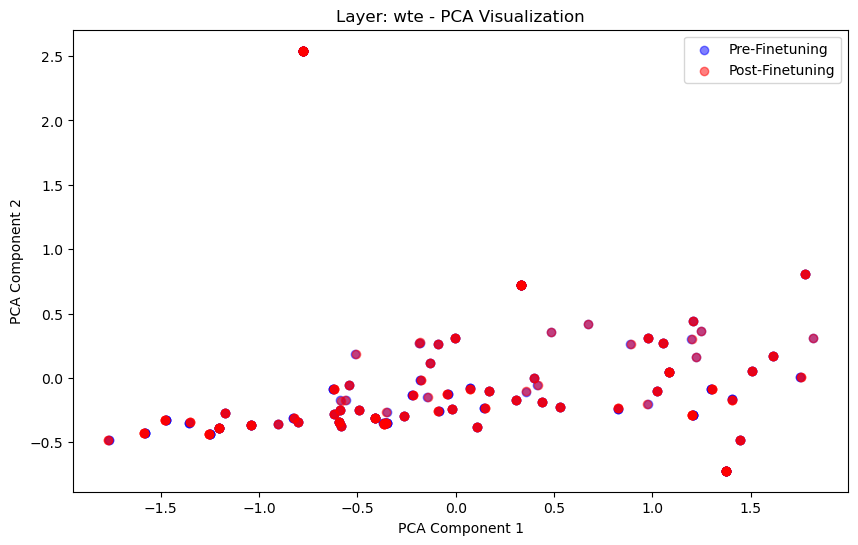

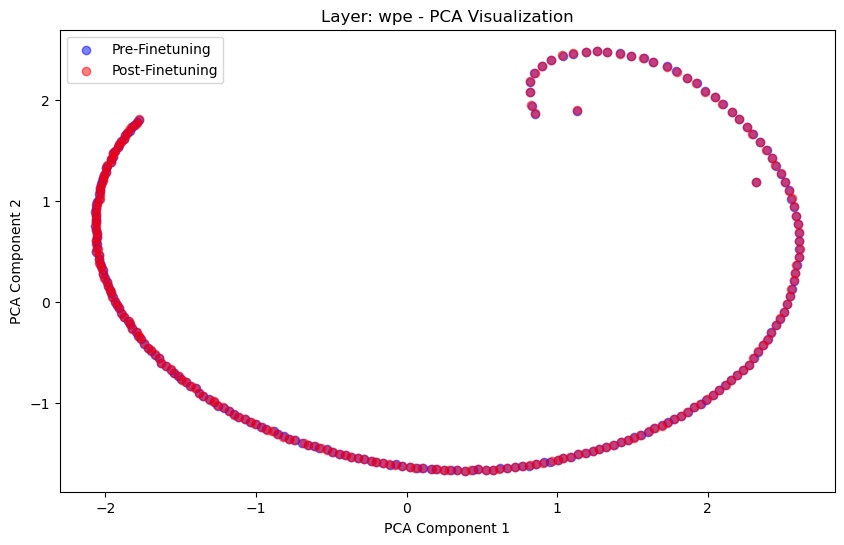

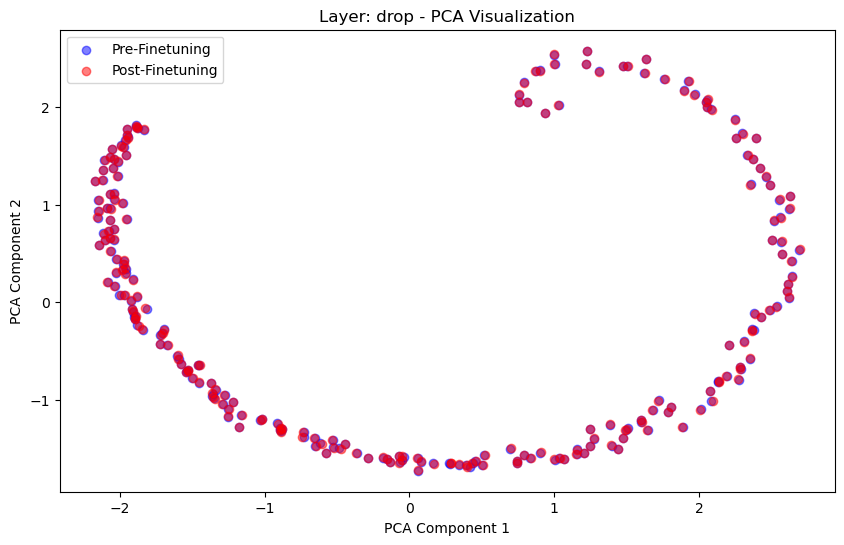

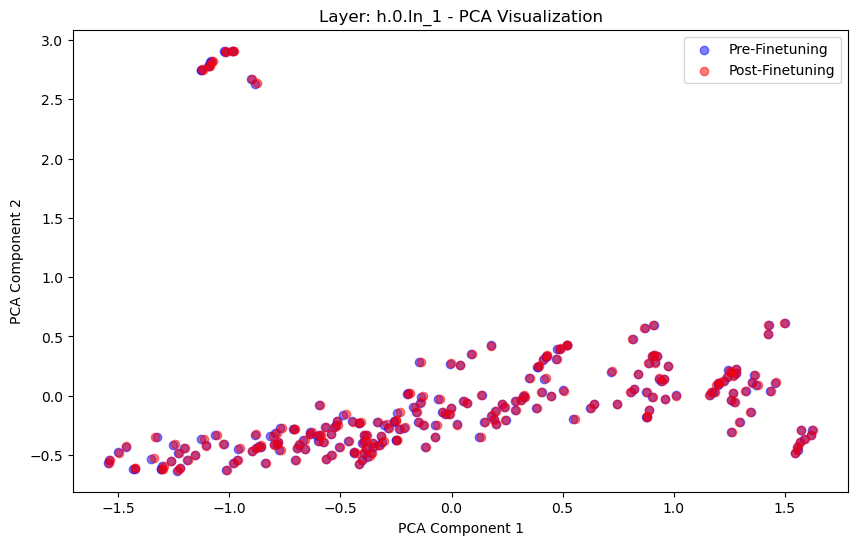

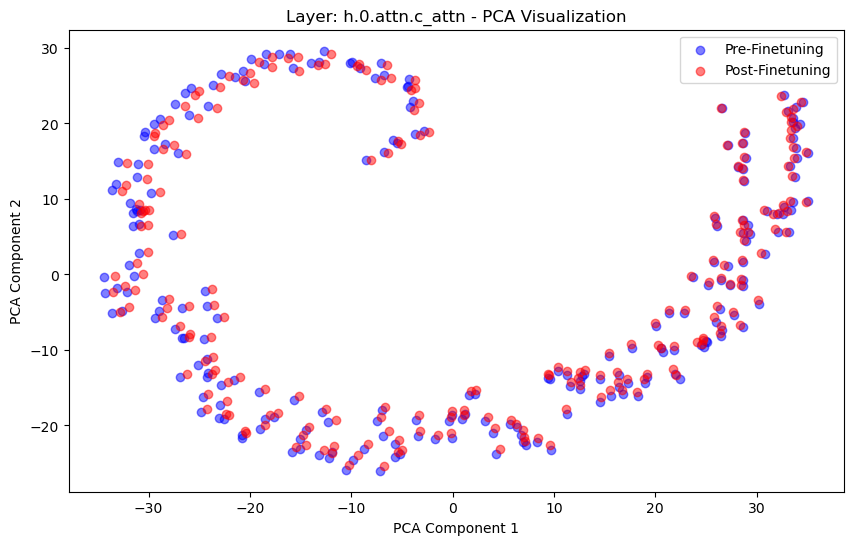

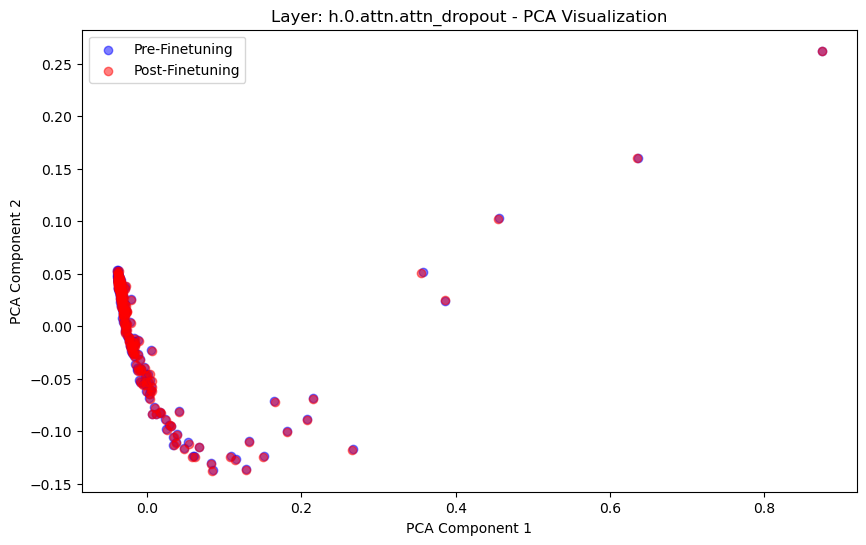

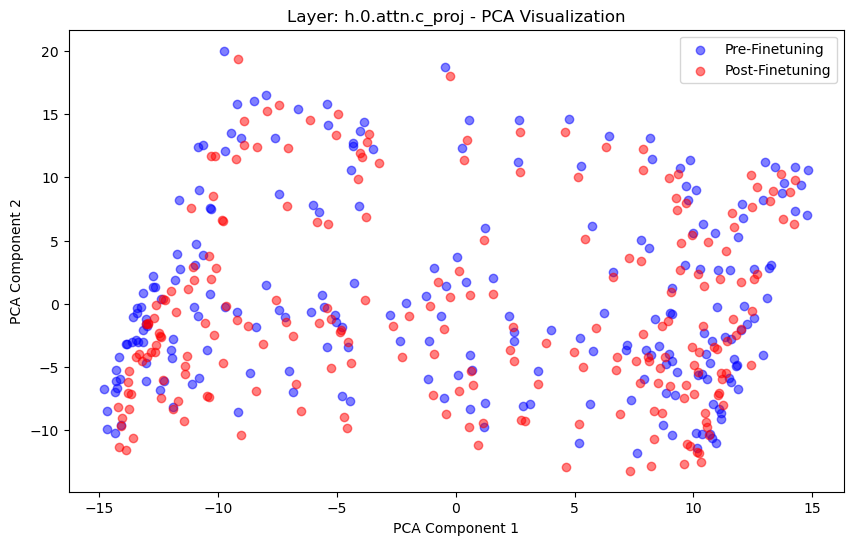

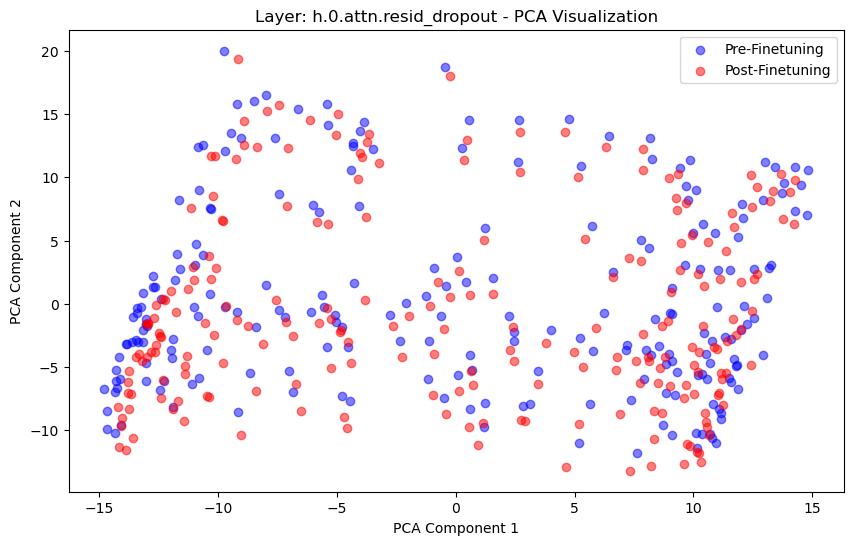

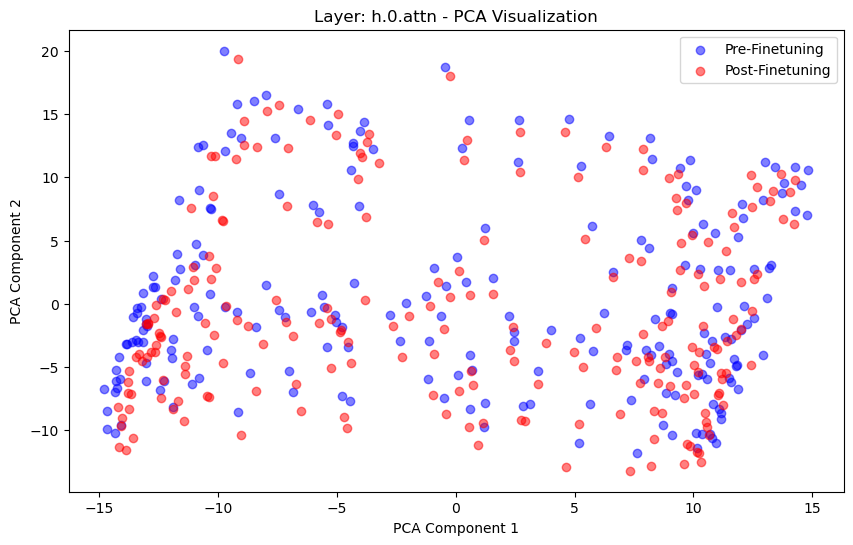

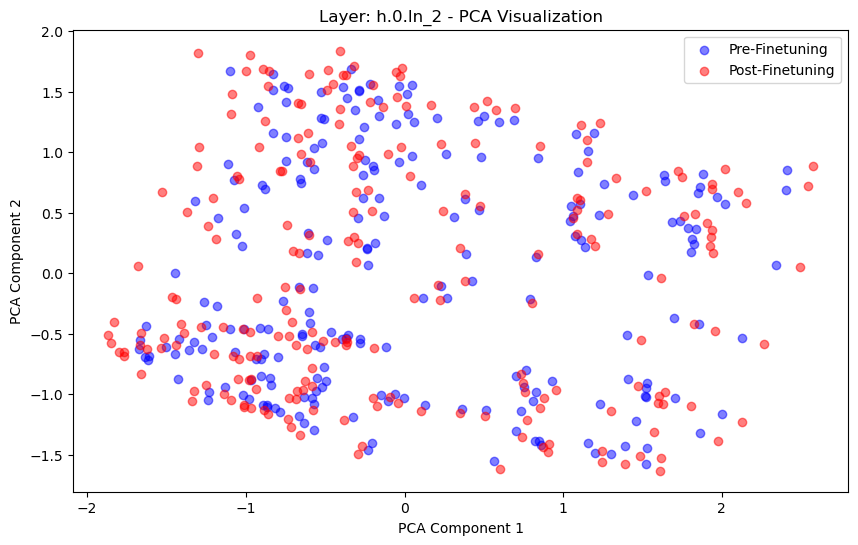

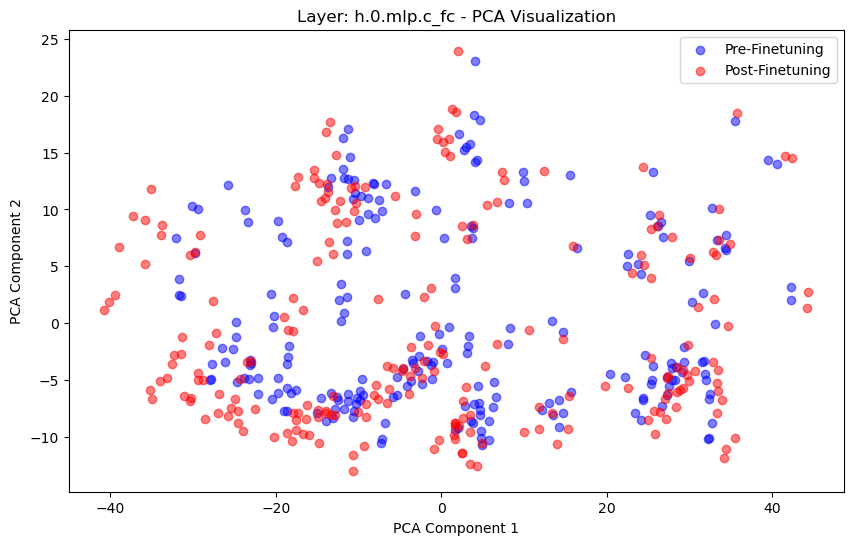

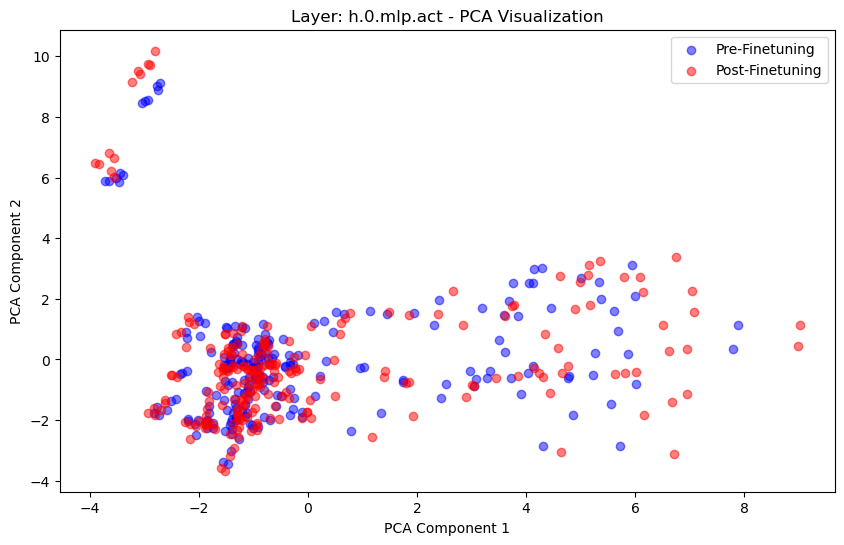

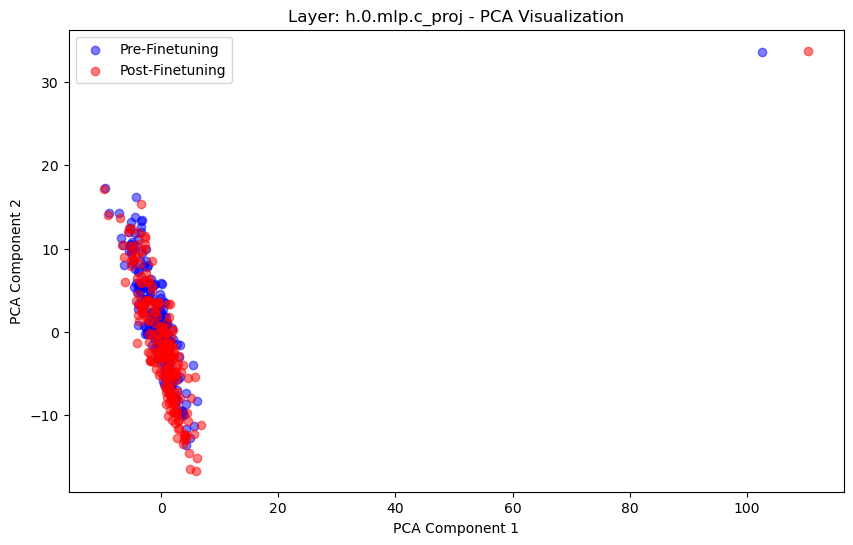

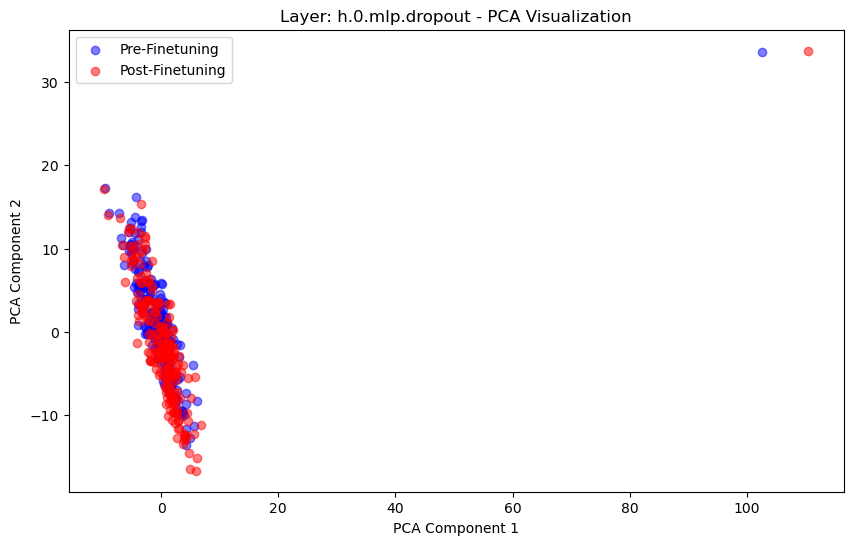

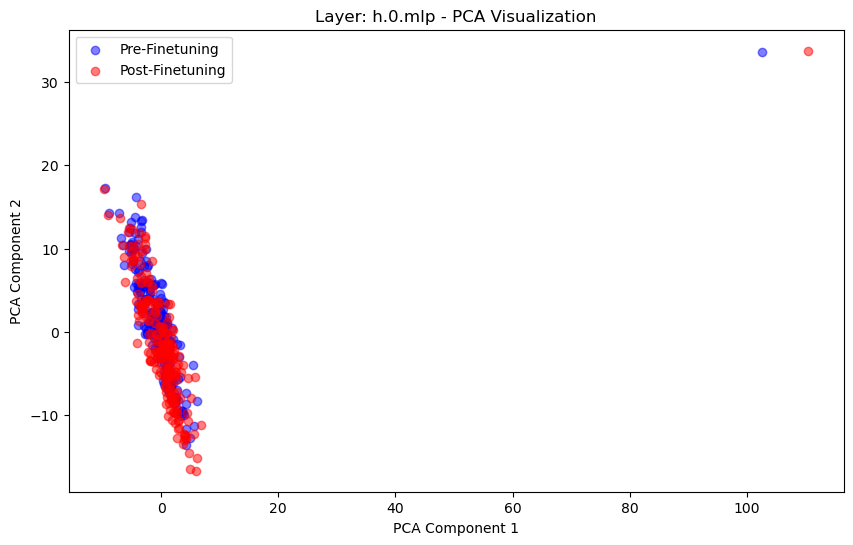

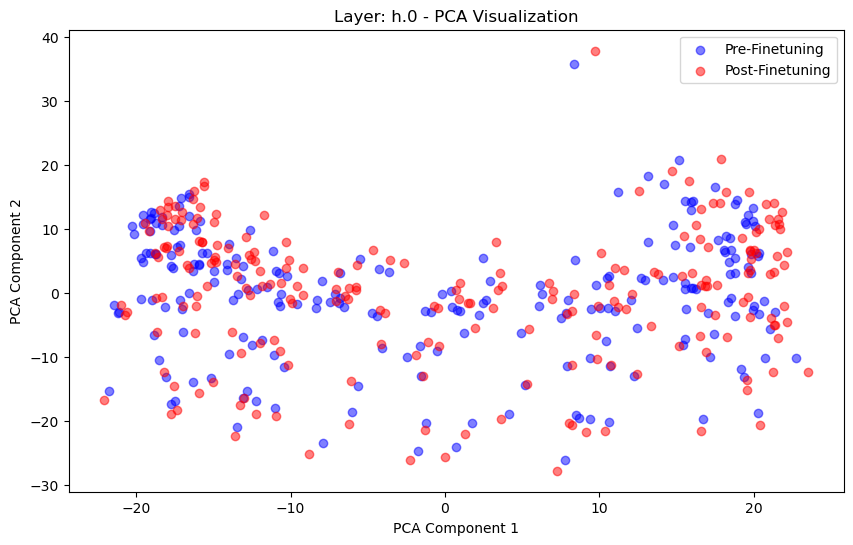

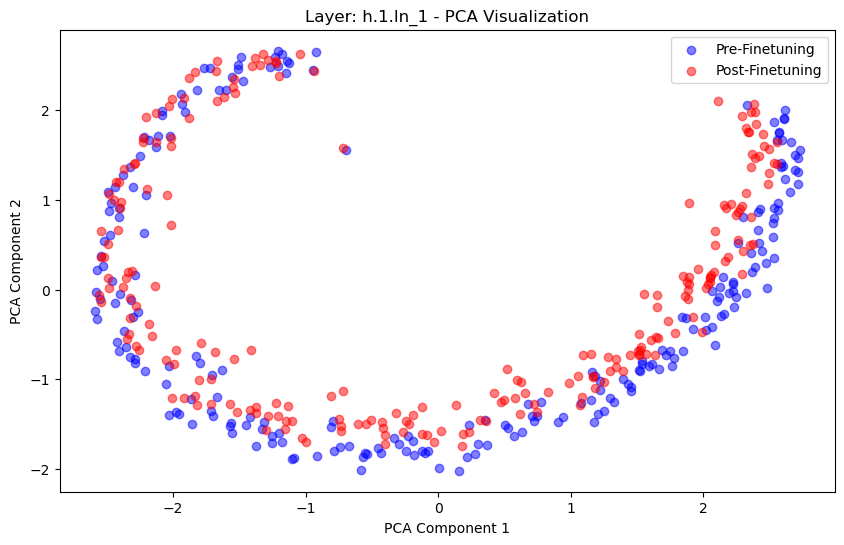

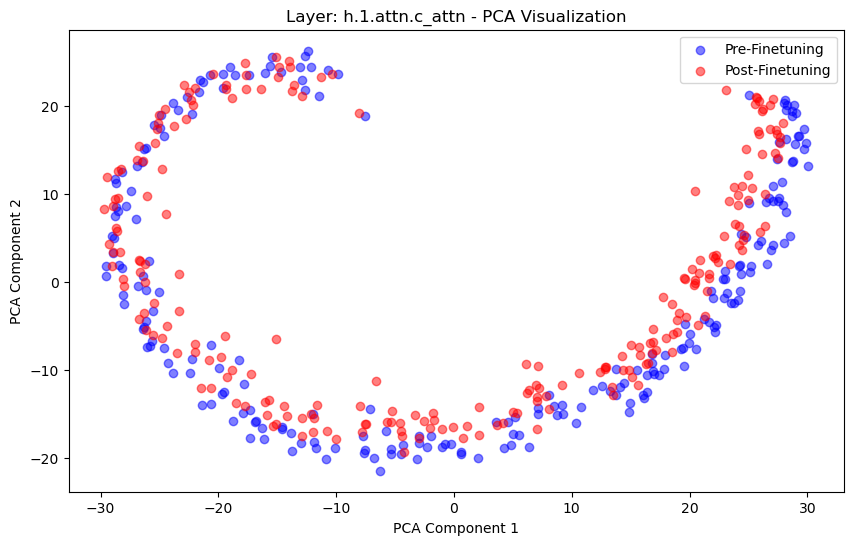

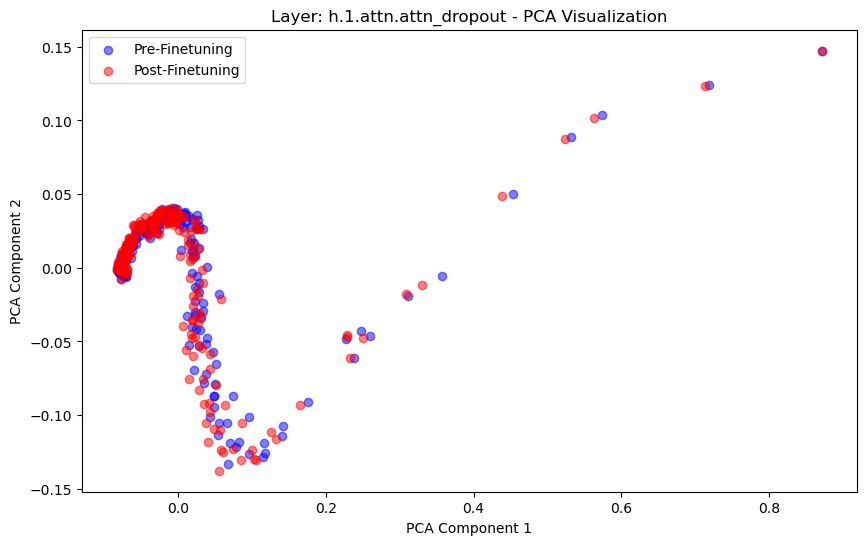

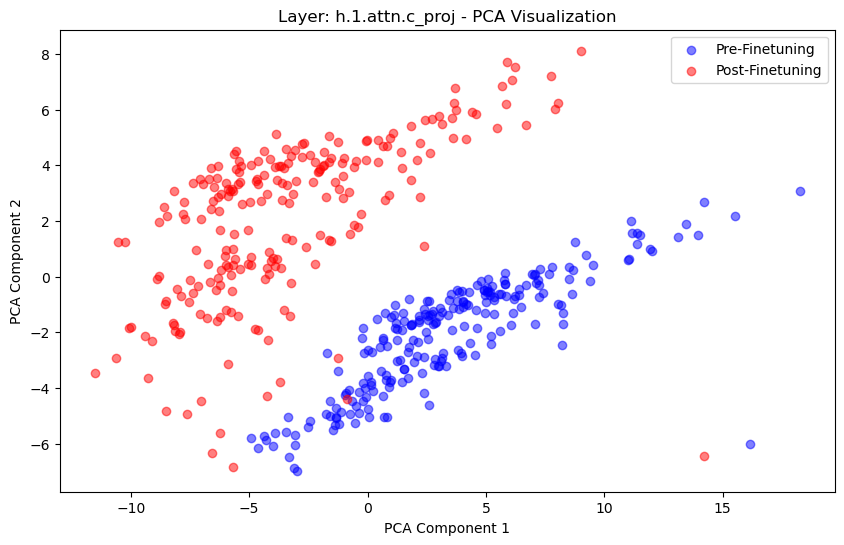

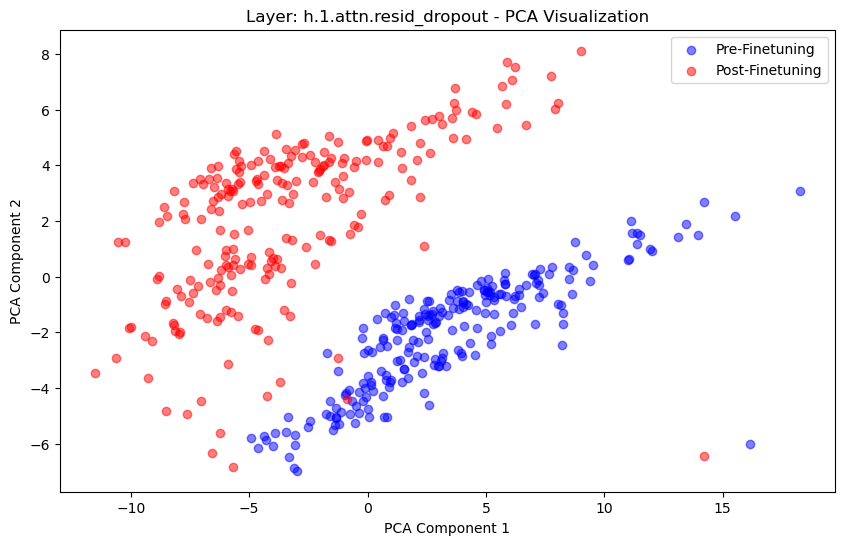

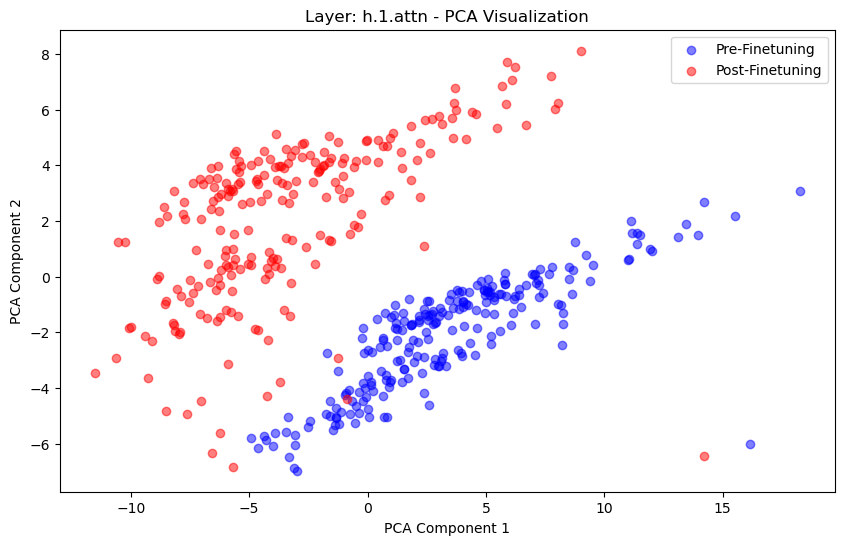

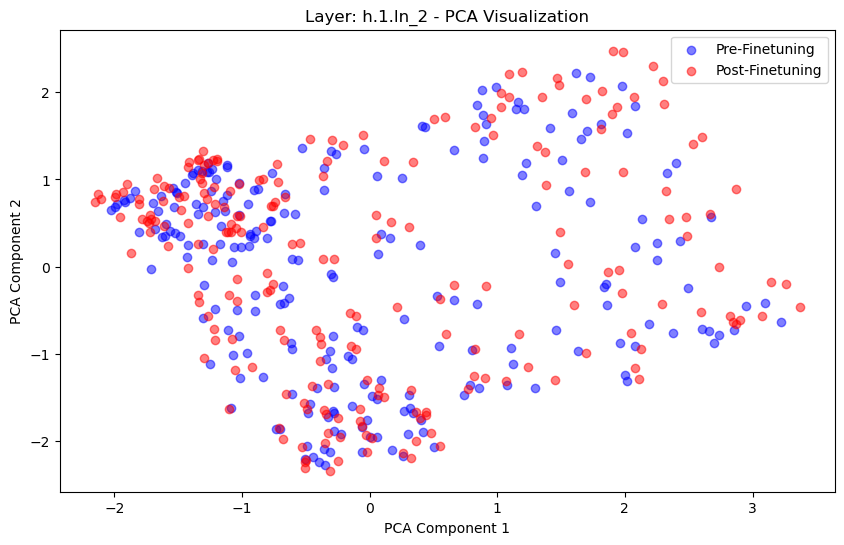

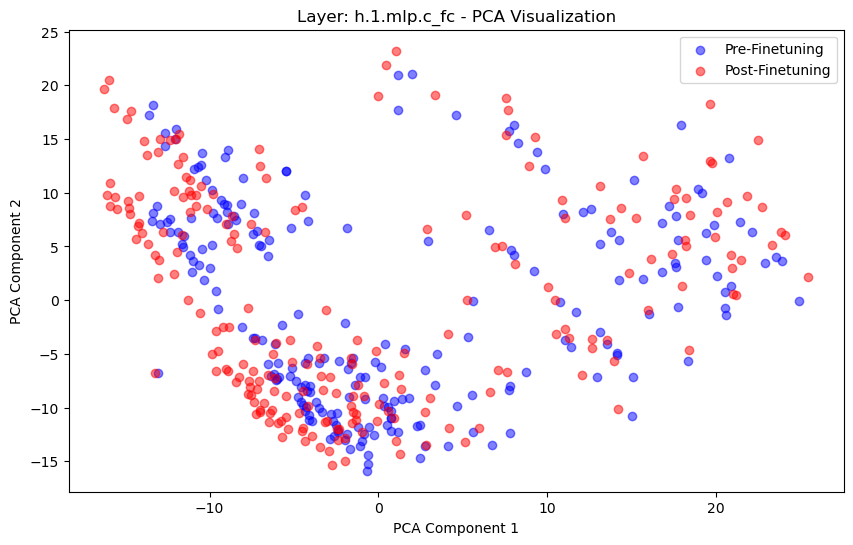

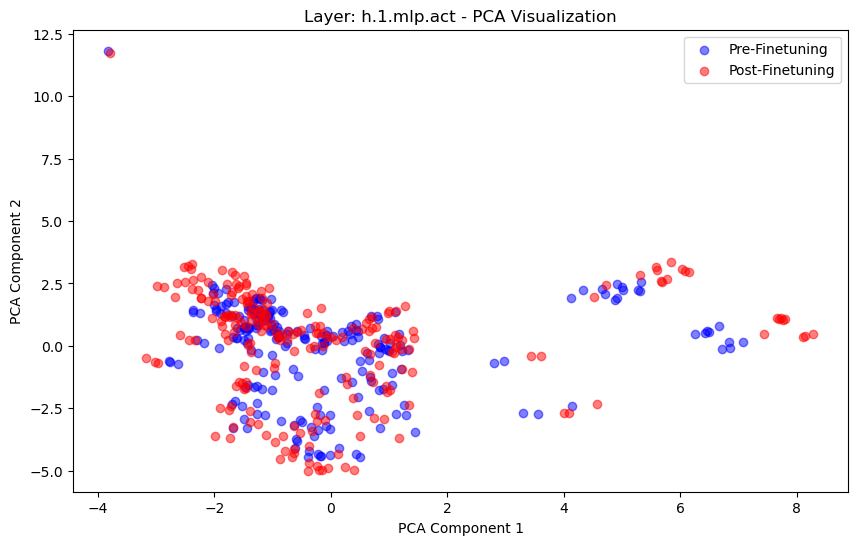

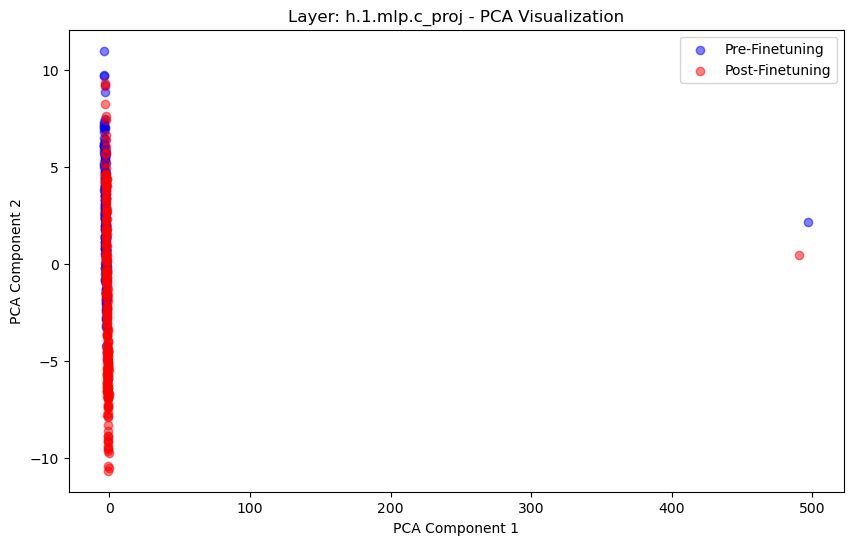

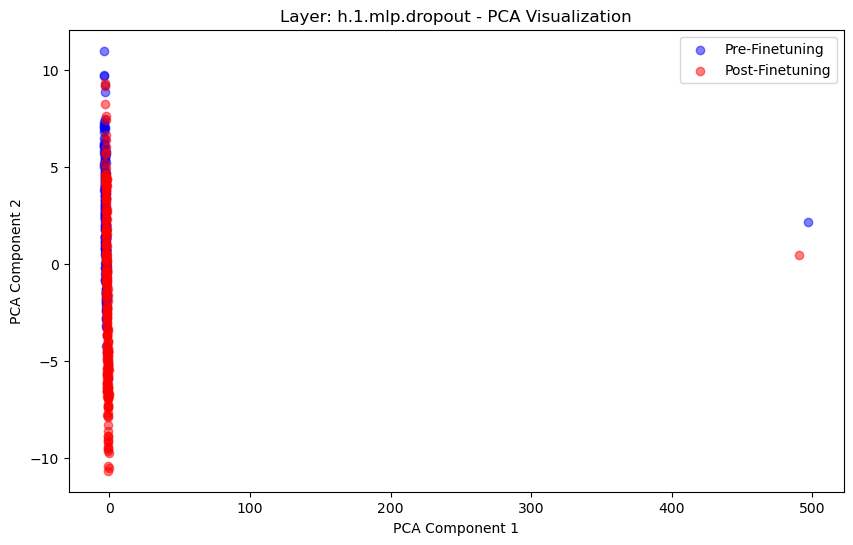

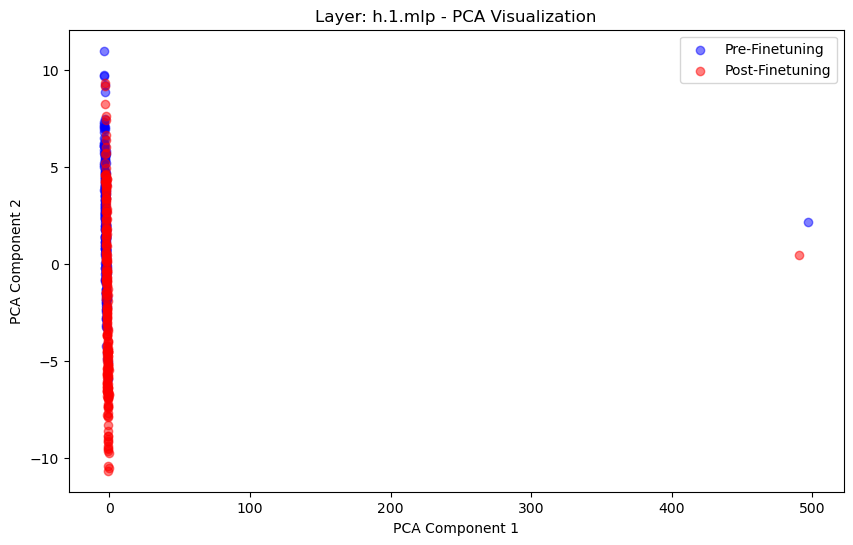

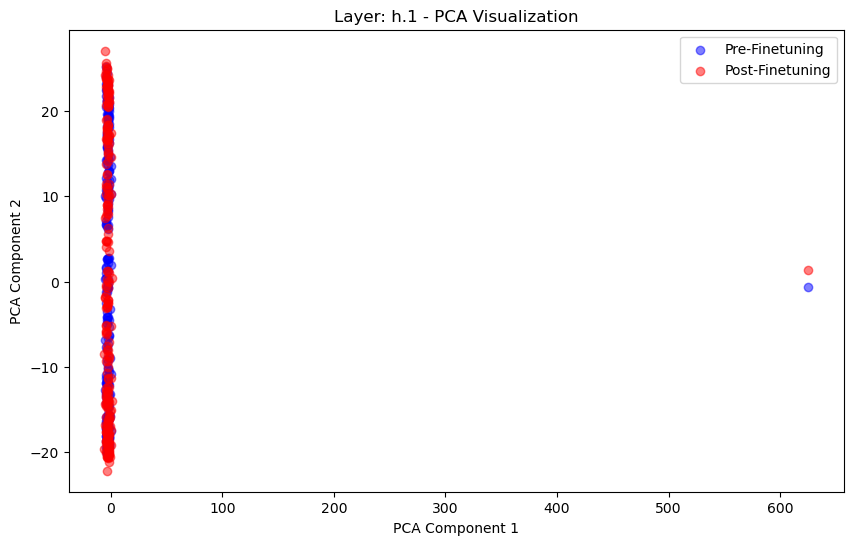

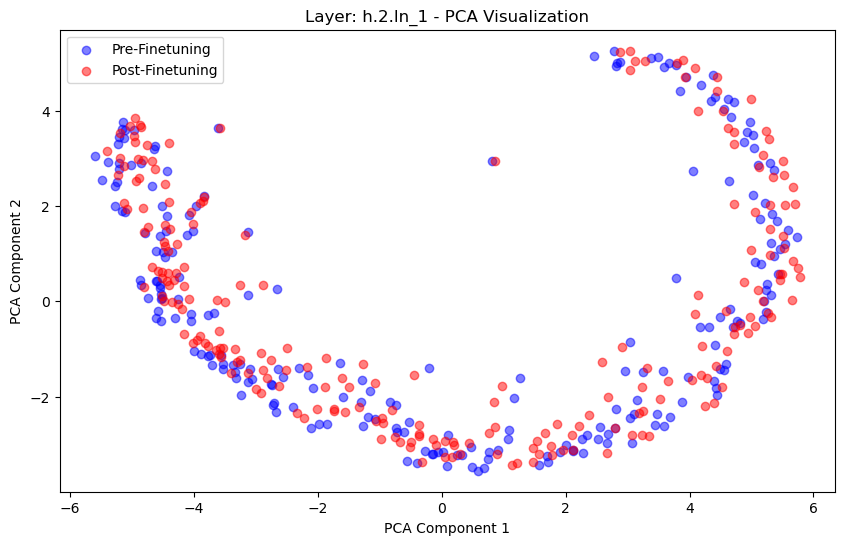

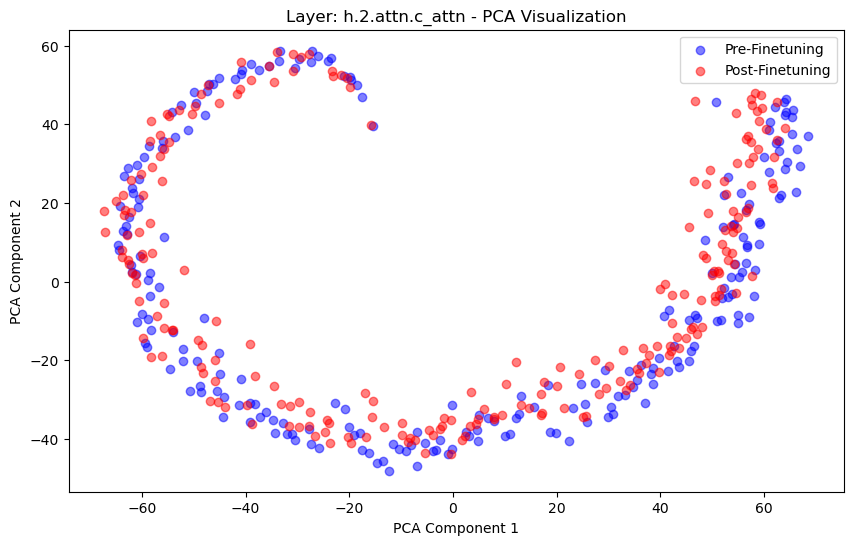

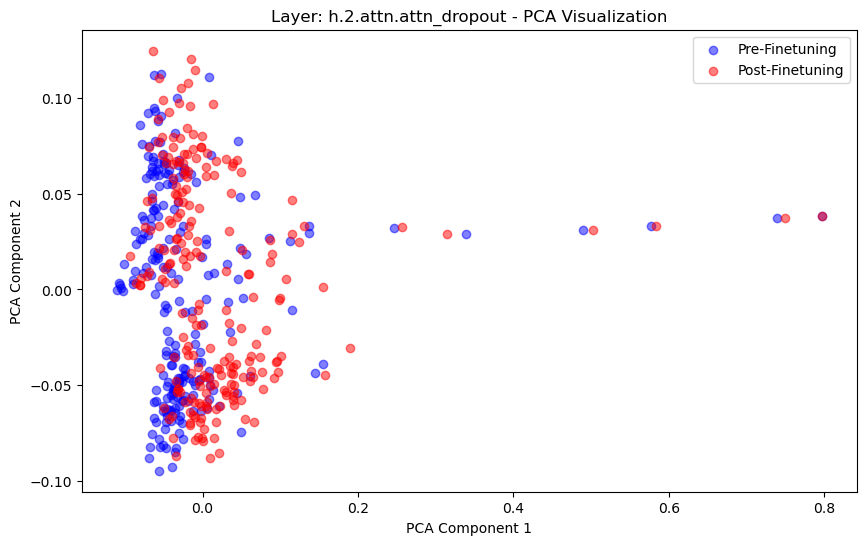

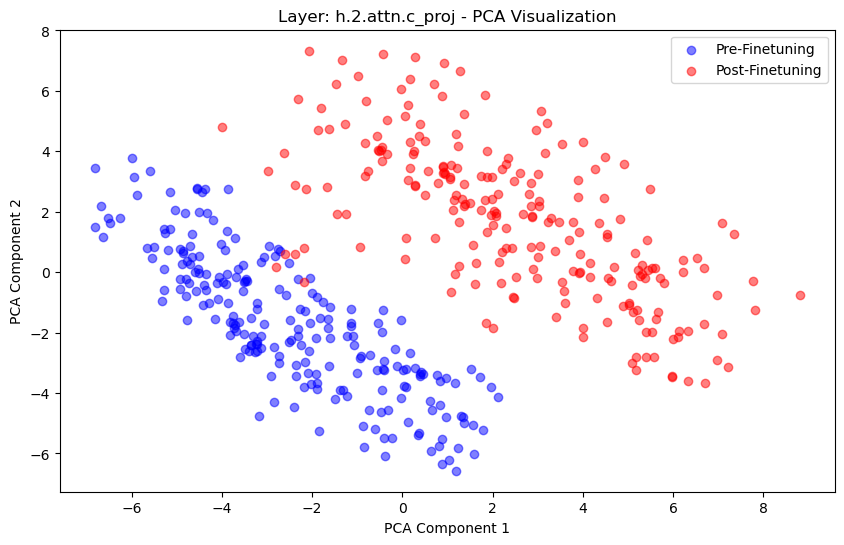

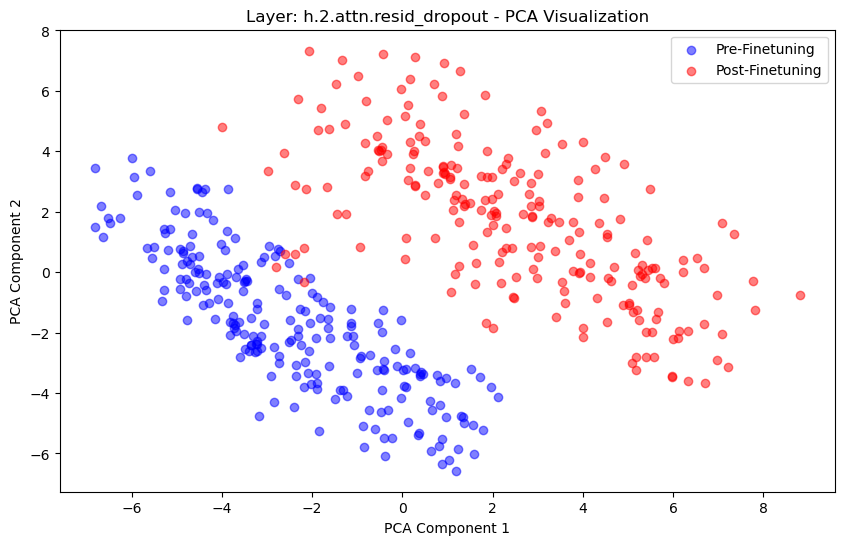

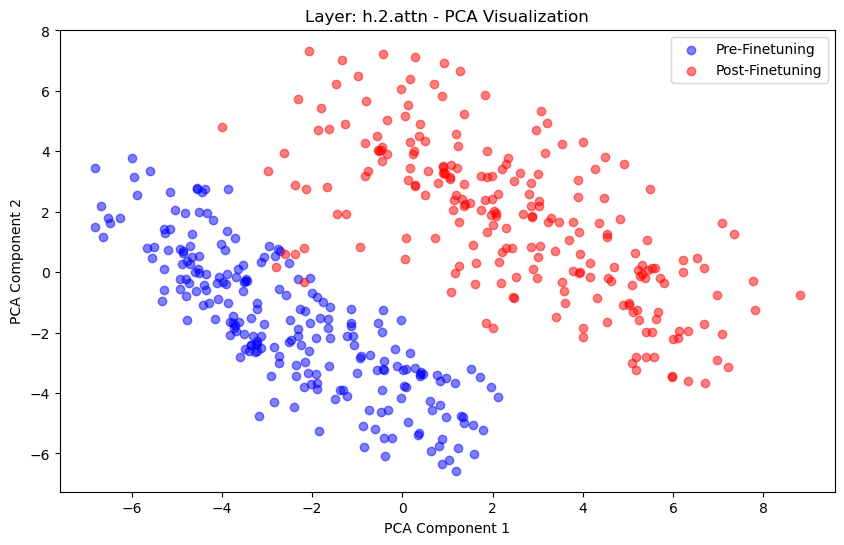

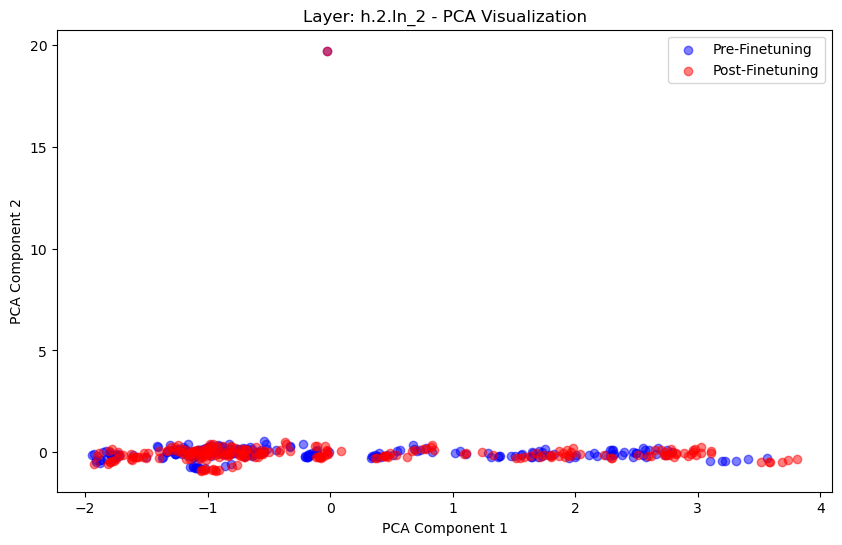

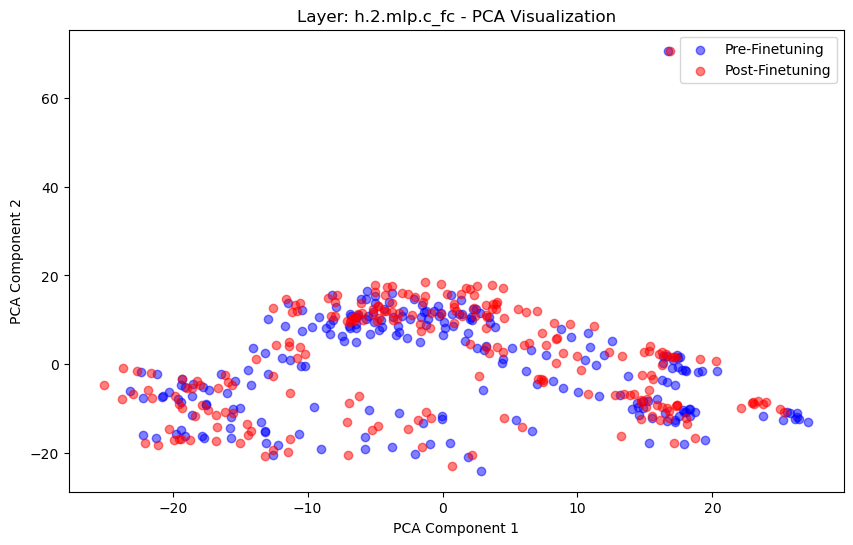

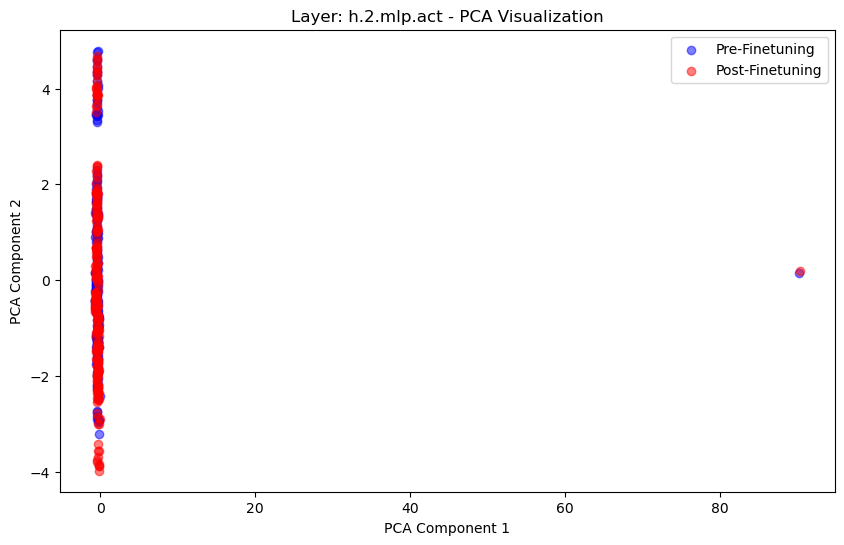

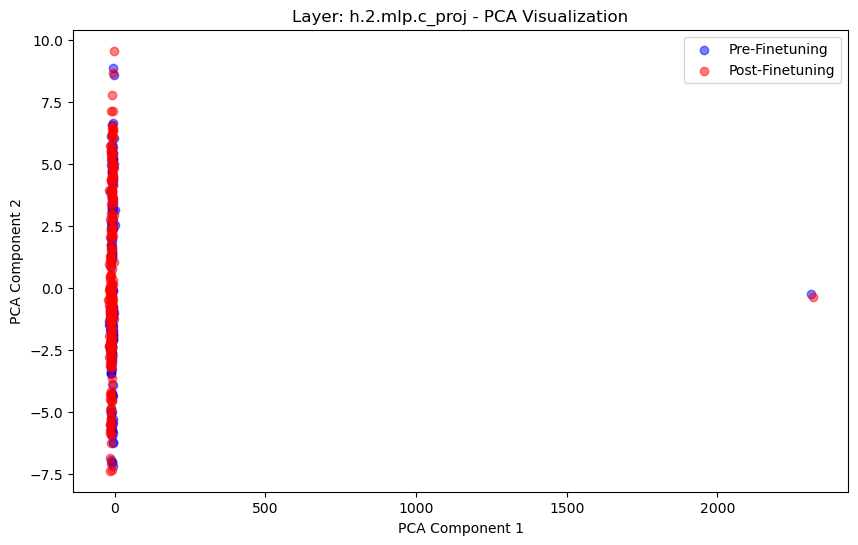

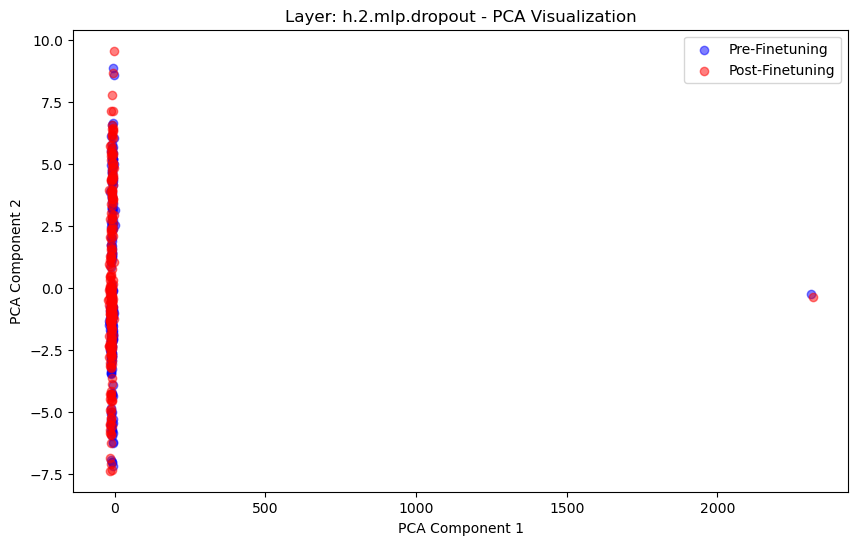

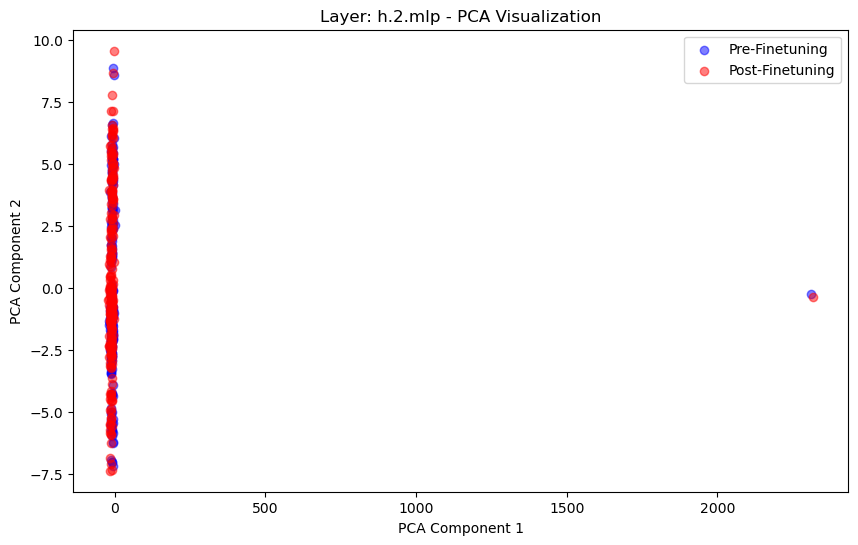

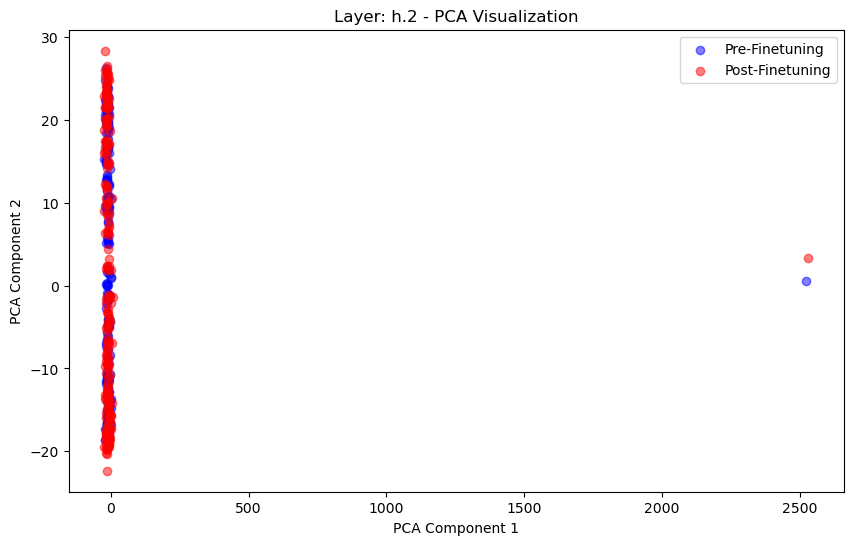

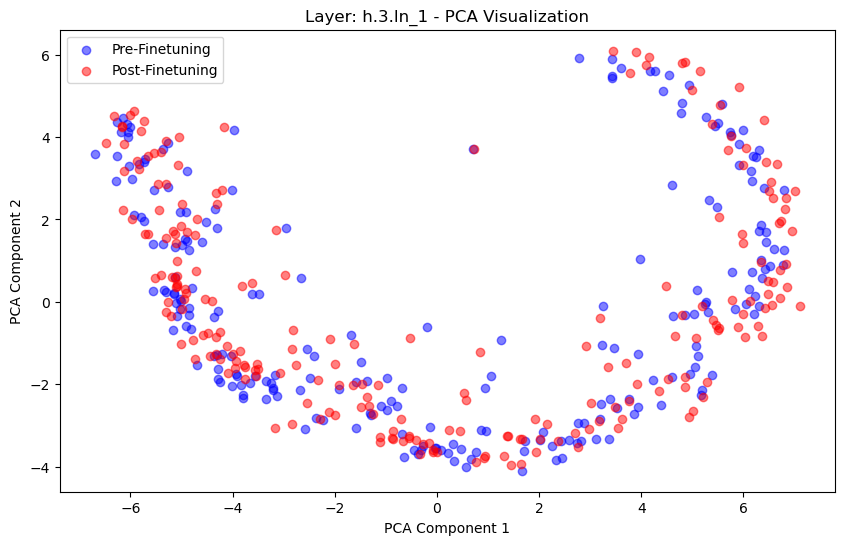

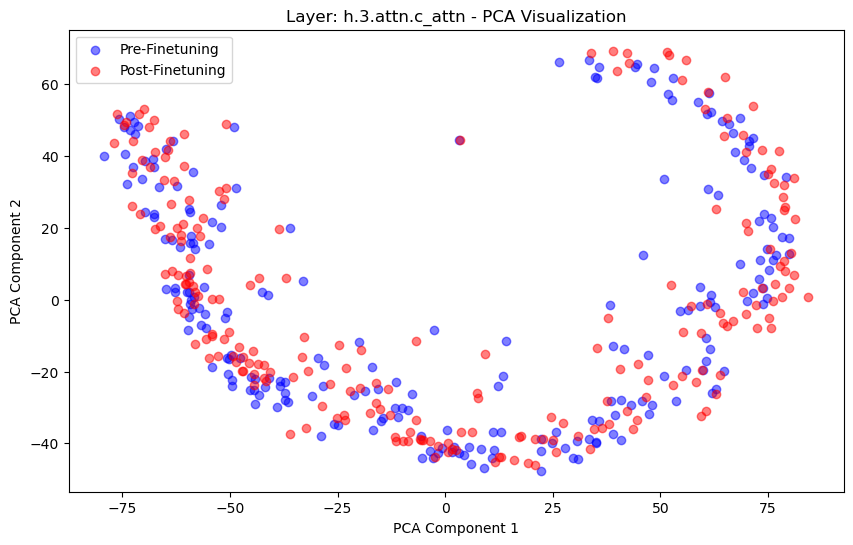

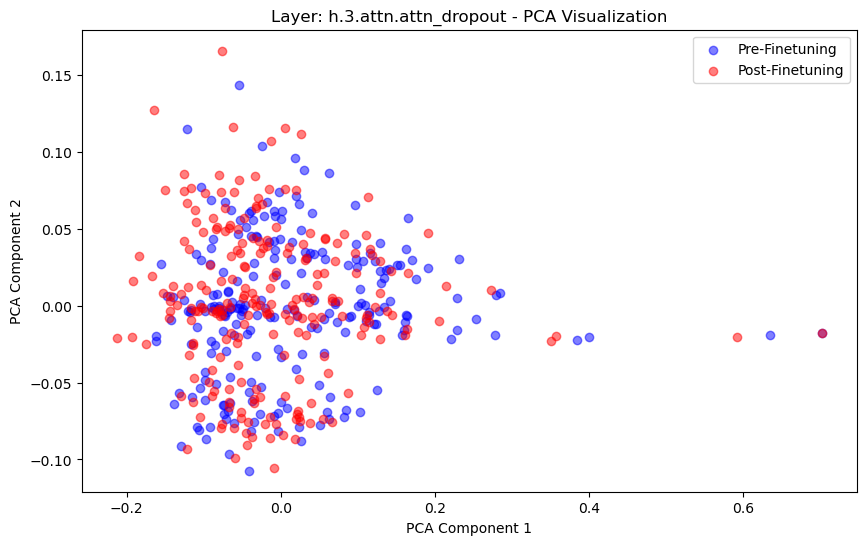

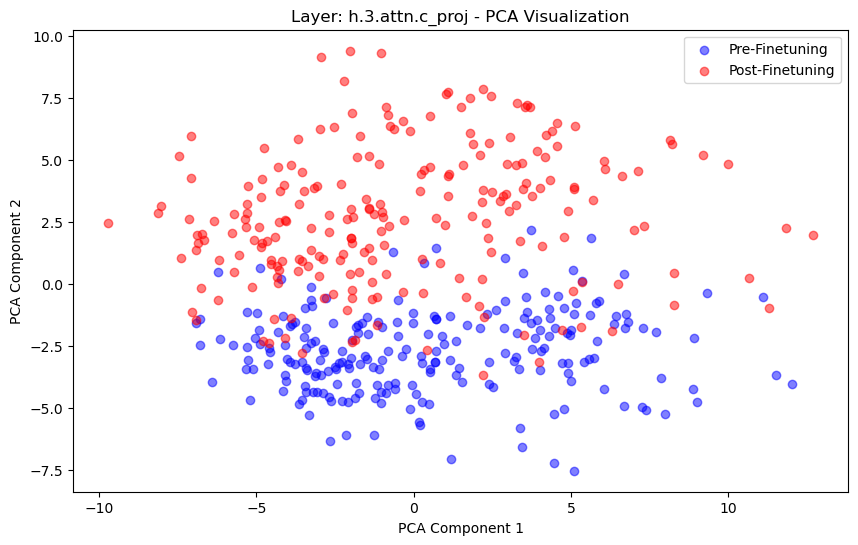

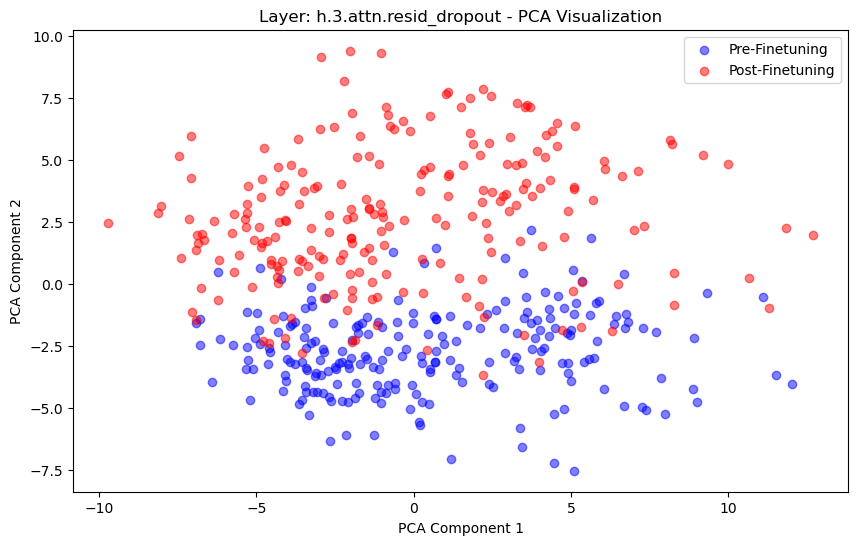

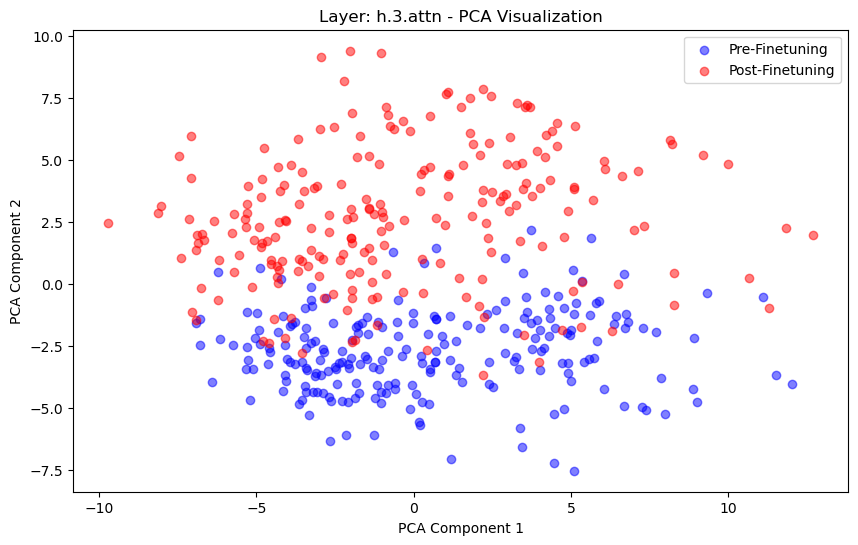

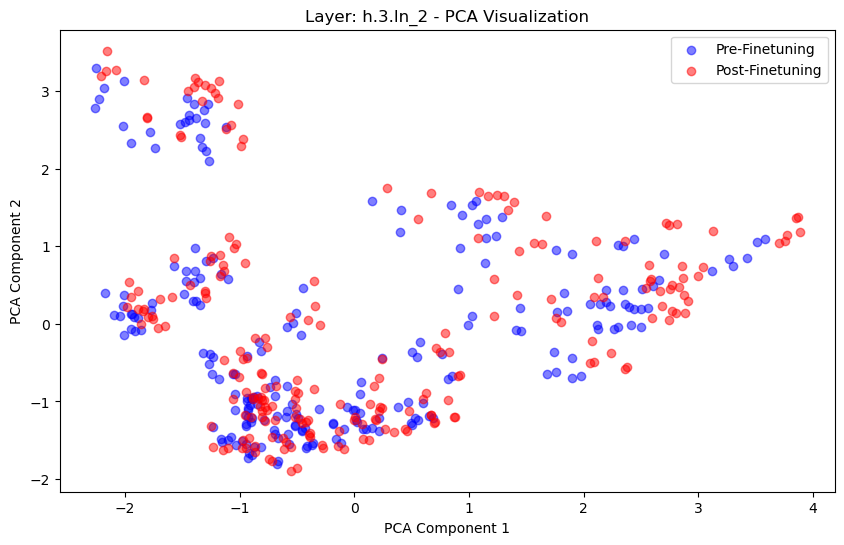

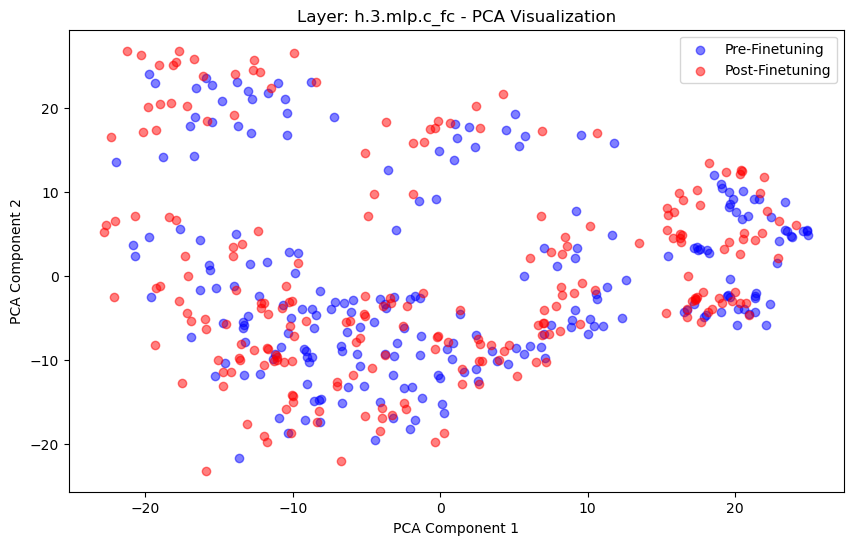

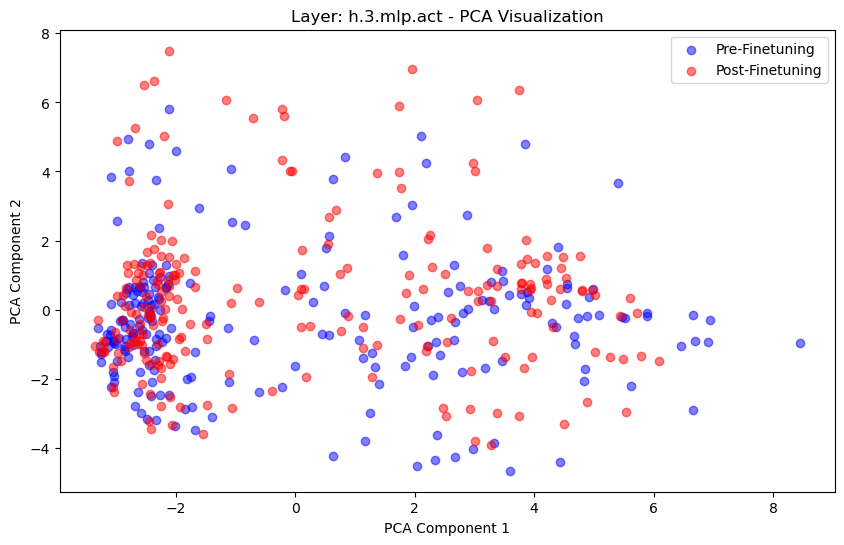

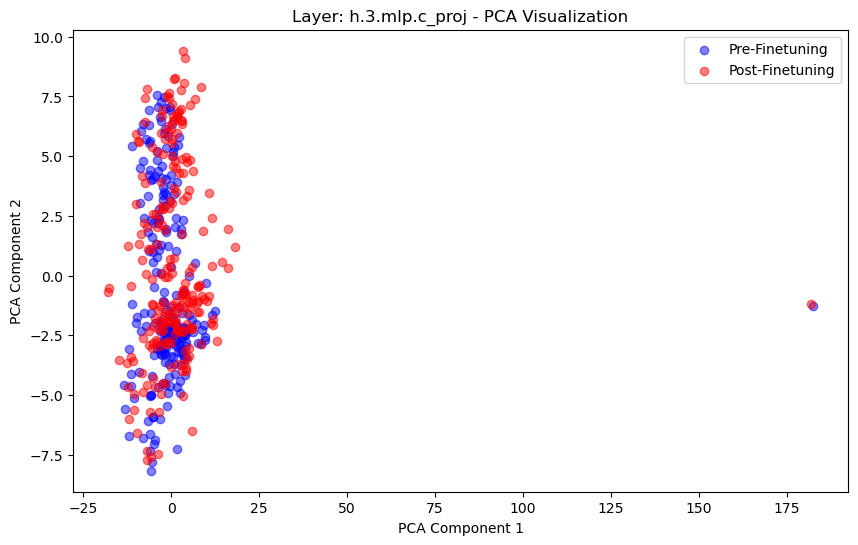

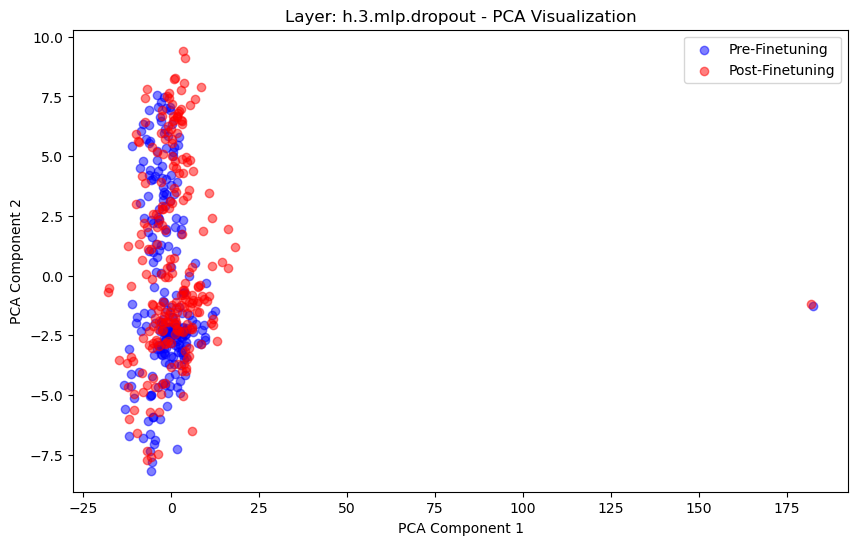

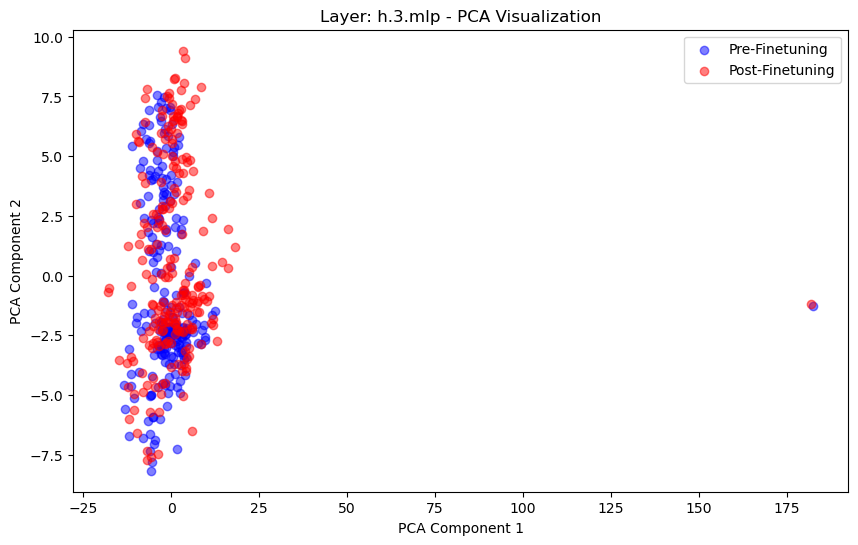

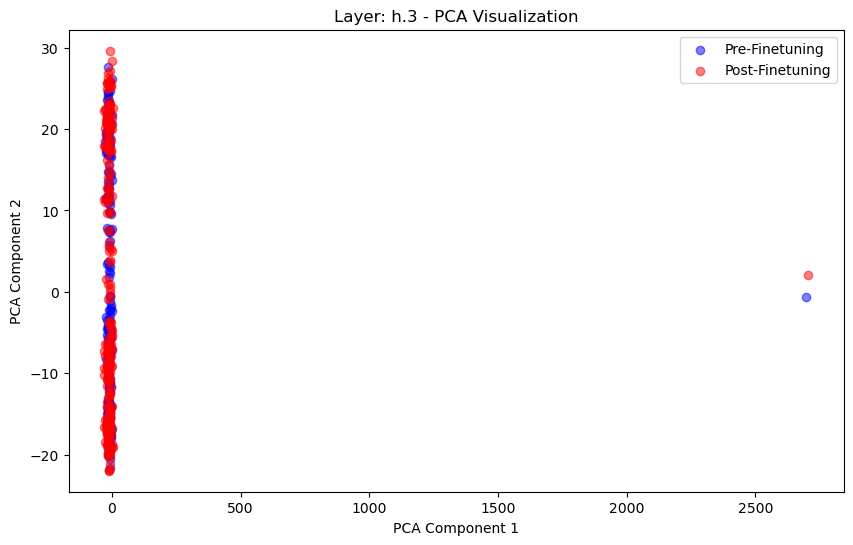

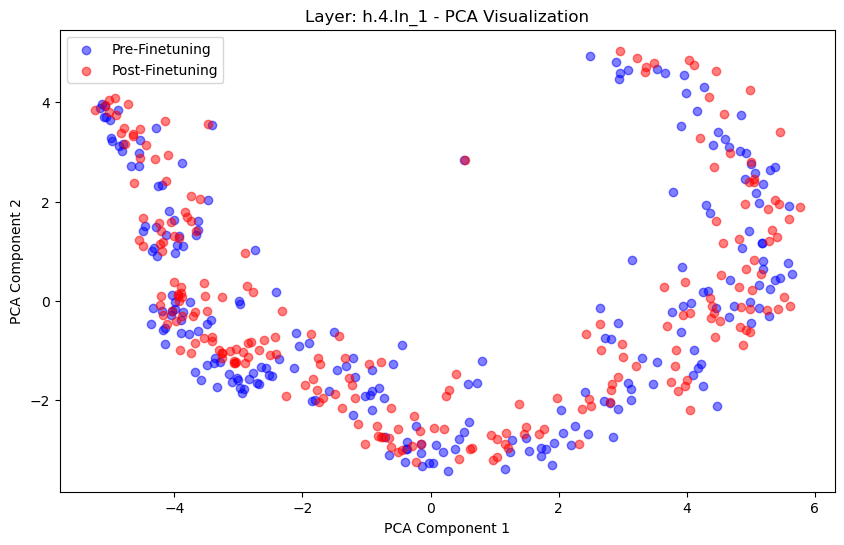

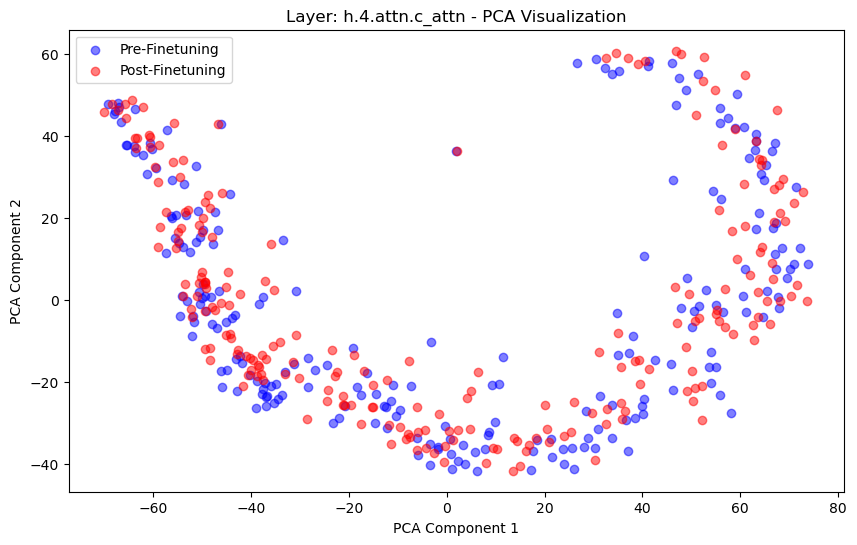

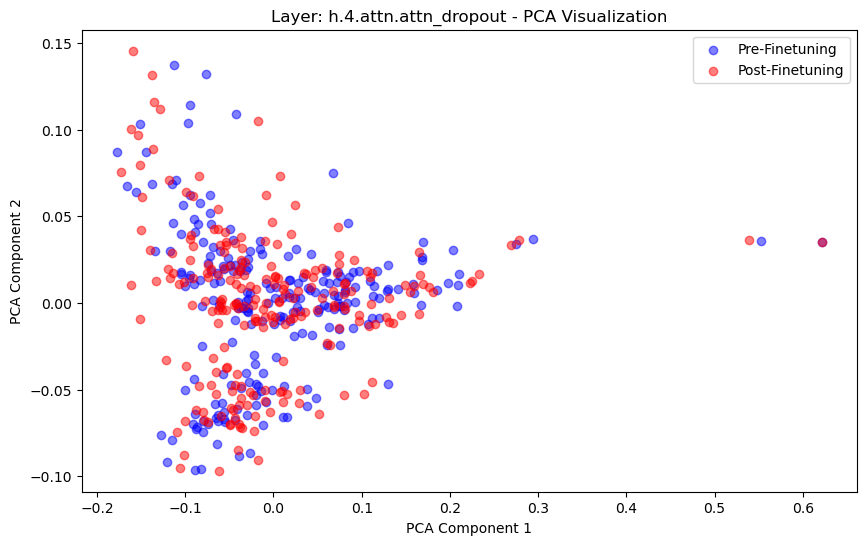

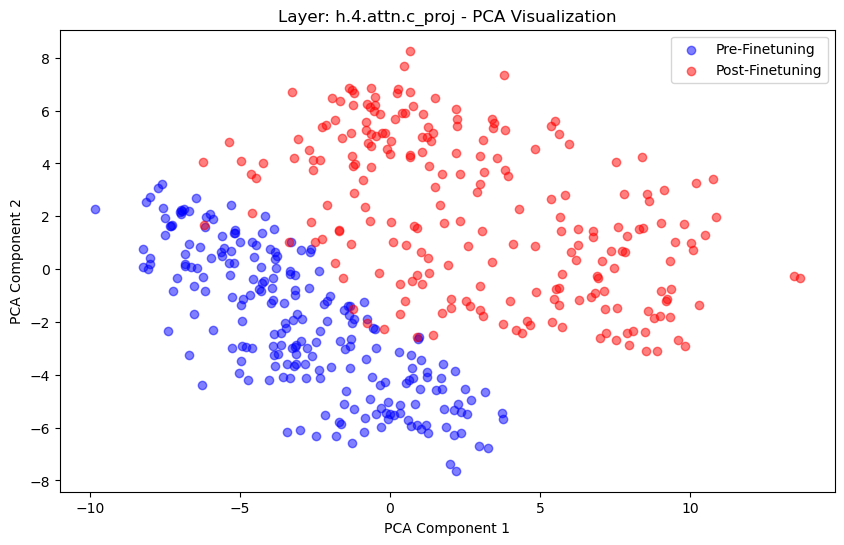

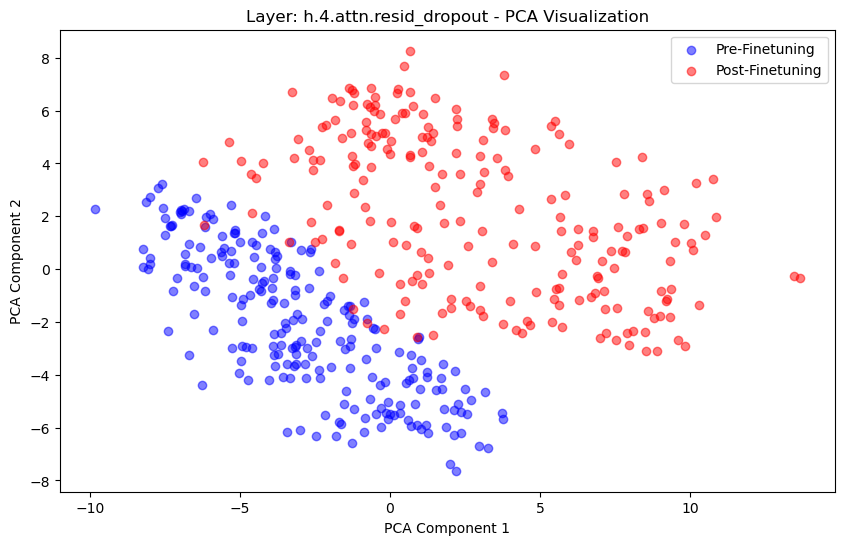

In [ ]:
layer_names = ['h.0', 'h.1', 'h.2', 'h.3', 'h.4', 'h.5', 'h.6', 'h.7', 'h.8', 'h.9', 'h.10', 'h.11']
for name in pre_ft_activations[1]:
    plot_activation_changes(pre_ft_activations, post_ft_activations, name)

In [49]:
for key in pre_ft_activations[1]:
    print(key)

wte
wpe
drop
h.0.ln_1
h.0.attn.c_attn
h.0.attn.attn_dropout
h.0.attn.c_proj
h.0.attn.resid_dropout
h.0.attn
h.0.ln_2
h.0.mlp.c_fc
h.0.mlp.act
h.0.mlp.c_proj
h.0.mlp.dropout
h.0.mlp
h.0
h.1.ln_1
h.1.attn.c_attn
h.1.attn.attn_dropout
h.1.attn.c_proj
h.1.attn.resid_dropout
h.1.attn
h.1.ln_2
h.1.mlp.c_fc
h.1.mlp.act
h.1.mlp.c_proj
h.1.mlp.dropout
h.1.mlp
h.1
h.2.ln_1
h.2.attn.c_attn
h.2.attn.attn_dropout
h.2.attn.c_proj
h.2.attn.resid_dropout
h.2.attn
h.2.ln_2
h.2.mlp.c_fc
h.2.mlp.act
h.2.mlp.c_proj
h.2.mlp.dropout
h.2.mlp
h.2
h.3.ln_1
h.3.attn.c_attn
h.3.attn.attn_dropout
h.3.attn.c_proj
h.3.attn.resid_dropout
h.3.attn
h.3.ln_2
h.3.mlp.c_fc
h.3.mlp.act
h.3.mlp.c_proj
h.3.mlp.dropout
h.3.mlp
h.3
h.4.ln_1
h.4.attn.c_attn
h.4.attn.attn_dropout
h.4.attn.c_proj
h.4.attn.resid_dropout
h.4.attn
h.4.ln_2
h.4.mlp.c_fc
h.4.mlp.act
h.4.mlp.c_proj
h.4.mlp.dropout
h.4.mlp
h.4
h.5.ln_1
h.5.attn.c_attn
h.5.attn.attn_dropout
h.5.attn.c_proj
h.5.attn.resid_dropout
h.5.attn
h.5.ln_2
h.5.mlp.c_fc
h.5.mlp.ac

In [ ]:
for i in range(10):
    plot_activation_changes_all_layers(pre_ft_activations, post_ft_activations, i)

In [ ]:
def plot_activation_changes(activation1, activation2, components=2, title=''):

    # copy tensors from cuda to host memory
    activation1 = activation1.cpu().numpy().reshape(1, -1)
    activation2 = activation2.cpu().numpy().reshape(1, -1)
    
    # Concatenate data from both states for unified transformation in PCA/t-SNE
    data_combined = np.concatenate([activation1, activation2], axis=0)
    
    reduced_data = TSNE(n_components=components, learning_rate='auto', init='random').fit_transform(data_combined)
    
    # Split the transformed data
    reduced_data_pre = reduced_data[:activation1.shape[0]]
    reduced_data_post = reduced_data[activation1.shape[0]:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data_pre[:, 0], reduced_data_pre[:, 1], c='blue', alpha=0.2, label='Pre-Finetuning')
    plt.scatter(reduced_data_post[:, 0], reduced_data_post[:, 1], c='red', alpha=0.2, label='Post-Finetuning')
    plt.title(f'{title} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_wide_changes_tsne(activations_pre, activations_post, layer_name, perplexity=30, learning_rate=200):
    """
    Visualize changes in activations for a particular layer across all data points using t-SNE.

    Parameters:
    activations_pre (dict): Activations from the model before finetuning, structured by data points.
    activations_post (dict): Activations from the model after finetuning, structured by data points.
    layer_name (str): Name of the layer to visualize changes for.
    perplexity (int): Perplexity parameter for t-SNE.
    learning_rate (int): Learning rate parameter for t-SNE.
    """
    # Collect activations for all data points in the specified layer
    data_pre = np.array([activations_pre[i][layer_name].cpu().numpy().flatten().reshape(-1) for i in range(len(activations_pre))])
    data_post = np.array([activations_post[i][layer_name].cpu().numpy().flatten().reshape(-1) for i in range(len(activations_post))])

    print(data_pre)
    # Combine data for t-SNE
    data_combined = np.vstack((data_pre, data_post))

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, init='random', random_state=42)
    tsne_results = tsne.fit_transform(data_combined)

    # Split the transformed data into pre- and post-finetuning groups
    tsne_pre = tsne_results[:len(data_pre)]
    tsne_post = tsne_results[len(data_pre):]

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_pre[:, 0], tsne_pre[:, 1], c='blue', label='Pre-Finetuning', alpha=0.5)
    plt.scatter(tsne_post[:, 0], tsne_post[:, 1], c='red', label='Post-Finetuning', alpha=0.5)
    plt.legend()
    plt.title(f't-SNE Visualization of Layer {layer_name} Activations Across All Data Points')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Example usage (ensure activations_pre and activations_post are correctly assigned from your data)
plot_layer_wide_changes_tsne(pre_ft_activations, post_ft_activations, 'h.11', perplexity=30, learning_rate=200)

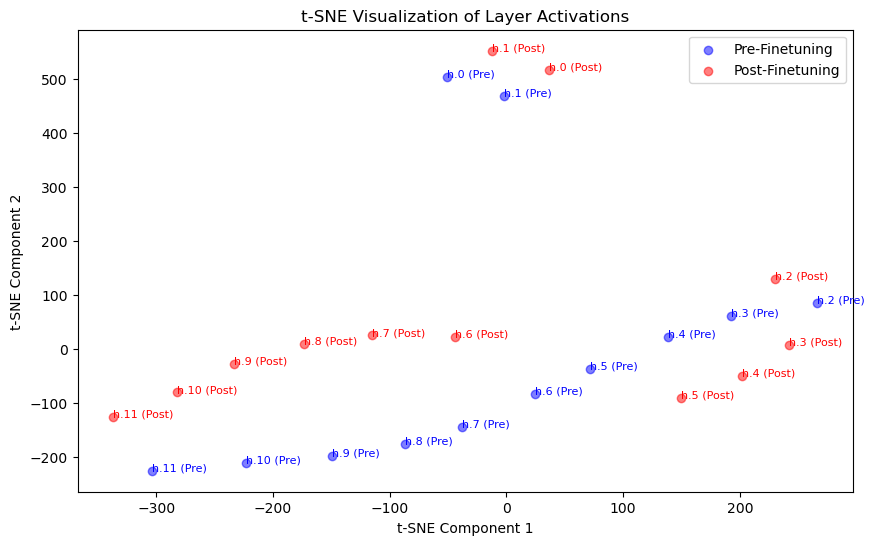

In [52]:
plot_layer_activations_tsne(pre_ft_activations, post_ft_activations, layer_names, 2)

In [ ]:
len(pre_ft_activations)

In [ ]:
for i in range(100):
    print(len(pre_ft_activations[i]['h.11'].cpu().numpy().flatten())) #or add .reshape(-1)